In [1]:
import numpy as np
import os
import math
import pandas as pd
import scipy.stats as stat
from scipy.stats import qmc
from scipy.stats import norm
from scipy.stats import skew, kurtosis
import scipy.interpolate
import statistics
from statistics import NormalDist
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Notebook parameters

swap_notional = 100000000
fixed_leg_interest = 0.042

stocks_notional = 1000000

bp_change = 0.0001

VaR_percentile = 5

In [3]:
def get_distribution_statistics(change):
    
    # Convert to NumPy array
    change = np.array(change)
    
    distribution_mean = change.mean()
    distribution_sd = change.std()
    distribution_skew = skew(change)
    distribution_kurtosis = kurtosis(change)  # Excess kurtosis (subtracts 3 from normal)
    
    # Create a summary table
    summary_table = pd.DataFrame({
        "Statistic": ["Mean", "Standard Deviation", "Skewness", "Kurtosis"],
        "Value": [distribution_mean, distribution_sd, distribution_skew, distribution_kurtosis]
    })

    return summary_table

In [4]:
def get_CVaR(change,var):
    
    # Convert to NumPy array
    change = np.array(change)
    
    tail_losses = change[change < var]
    
    cvar = tail_losses.mean()
    
    print(f"Conditional Value at Risk (CVaR) at the {VaR_percentile}% percentile is ${cvar:.2f}")

In [5]:
def plot_histogram(change, var, title):
    
    # Convert to NumPy array
    change = np.array(change)
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 7))
    plt.title(title)
    plt.hist(change, 
             density = True, 
             bins = 100)
    
    plt.axvline(x = -var, color = 'r')

    mu, std = norm.fit(change)
    xmin, xmax = change.min(), change.max()
    x = np.linspace(xmin, xmax, 10000)
    p = norm.pdf(x, mu, std)
    
    plt.plot(x, p, 'k', linewidth=2)

    ax.xaxis.set_major_formatter('${x:1,.0f}');

# 👉 <a id = "top">Table of Contents</a> 👈 

# [1. Download Data](#p1)

# [2. Preprocess Swap Data](#p2)

# [3. Preprocess Stock Data](#p3)

# [4. Check if Dates in Swaps and Stocks are the same](#p4)

# [5. Combine the Swaps and Stocks data](#p5)

# [6. Convert from swap rates to discount factors](#p6)

# [7. Calculate PV01](#p7)

# [8. Calculate mean vector and covariance matrix](#p8)

# [9. Parametric VaR Model](#p9)

### [9a. Stocks Only Parametric VaR Model](#p9a)

### [9b. Swaps Only Parametric VaR Model](#p9b)

# [10. Monte Carlo VaR Model](#p10)

### [10a. Monte Carlo VaR Full Revaluation](#p10a)

### [10b. Monte Carlo VaR Sensitivity-Based Revaluation](#p10b)

### [10c. Stocks Only Monte Carlo VaR Revaluation](#p10c)

### [10d. Swaps Only Monte Carlo VaR Revaluation](#p10d)

# [11. Historical VaR Model](#p11)

### [11a. Historical VaR Full Revaluation](#p11a)

### [11b. Historical VaR Sensitivity-Based Revaluation](#p11b)

### [11c. Stock Only Historical VaR Revaluation](#p11c)

### [11d. Swaps Only Historical VaR Revaluation](#p11d)

# <a id = "p1">1.</a>  <font color = "green"> Download Data </font>  [back to table of contents](#top)

In [6]:
SOFR = pd.read_excel("hist_data.xlsm",
                     sheet_name="SofrCurve")

SOFR 

,Tenor,T,2022-10-31 00:00:00,2022-11-01 00:00:00,2022-11-02 00:00:00,2022-11-03 00:00:00,2022-11-04 00:00:00,2022-11-07 00:00:00,2022-11-08 00:00:00,2022-11-09 00:00:00,...,2023-10-17 00:00:00,2023-10-18 00:00:00,2023-10-19 00:00:00,2023-10-20 00:00:00,2023-10-23 00:00:00,2023-10-24 00:00:00,2023-10-25 00:00:00,2023-10-26 00:00:00,2023-10-27 00:00:00,2023-10-30 00:00:00
0,1D,0.002778,0.039191,0.039604,0.039948,0.040389,0.045965,0.040224,0.040339,0.040373,...,0.052964,0.053038,0.053050,0.053072,0.053090,0.053105,0.052981,0.053047,0.052989,0.052967
1,1M,0.083333,0.038721,0.039023,0.039286,0.039585,0.042343,0.039258,0.039211,0.039193,...,0.053114,0.053102,0.053086,0.053046,0.053077,0.053084,0.053057,0.053089,0.053040,0.053053
2,2M,0.166667,0.038670,0.038886,0.039100,0.039350,0.038795,0.039460,0.039420,0.039483,...,0.053374,0.053284,0.053226,0.053128,0.053191,0.053202,0.053259,0.053218,0.053185,0.053265
3,3M,0.250000,0.040536,0.040725,0.040852,0.041154,0.040611,0.041424,0.041406,0.041445,...,0.053666,0.053561,0.053454,0.053323,0.053404,0.053424,0.053490,0.053414,0.053368,0.053476
4,6M,0.500000,0.044577,0.044849,0.044884,0.045281,0.045212,0.045455,0.045334,0.045299,...,0.054078,0.053989,0.053758,0.053546,0.053638,0.053690,0.053749,0.053567,0.053486,0.053612
5,9M,0.750000,0.046004,0.046448,0.046580,0.047107,0.046752,0.047189,0.046941,0.046883,...,0.053831,0.053753,0.053427,0.053126,0.053211,0.053293,0.053393,0.053089,0.052991,0.053120
6,1Y,1.000000,0.046449,0.046970,0.047203,0.047894,0.047500,0.047929,0.047589,0.047479,...,0.053225,0.053163,0.052750,0.052348,0.052389,0.052503,0.052653,0.052243,0.052115,0.052245
7,2Y,2.000000,0.044583,0.045022,0.045496,0.046594,0.046097,0.046633,0.046046,0.045585,...,0.049497,0.049611,0.049204,0.048366,0.048027,0.048399,0.048791,0.048044,0.047758,0.047904
8,3Y,3.000000,0.042002,0.042344,0.042749,0.043833,0.043385,0.043884,0.043209,0.042645,...,0.046978,0.047304,0.047169,0.046151,0.045582,0.045999,0.046595,0.045645,0.045284,0.045429
9,4Y,4.000000,0.040318,0.040614,0.040868,0.041825,0.041503,0.041916,0.041182,0.040704,...,0.045605,0.046034,0.046195,0.045156,0.044508,0.044850,0.045594,0.044538,0.044200,0.044345


In [7]:
AAPL = pd.read_excel("hist_data.xlsm",
                     sheet_name="AAPL",
                     index_col=0)

AAPL.rename(columns = {"Adj Close":"AAPL"},
            inplace=True)

AAPL

,AAPL
Date,
2022-10-31,152.041122
2022-11-01,149.373917
2022-11-02,143.801514
2022-11-03,137.703613
2022-11-04,137.435455
...,...
2023-10-24,172.991058
2023-10-25,170.657135
2023-10-26,166.458023


In [8]:
MSFT = pd.read_excel("hist_data.xlsm",
                     sheet_name="MSFT",
                     index_col=0)

MSFT.rename(columns = {"Adj Close":"MSFT"},
            inplace=True)

MSFT

,MSFT
Date,
2022-10-31,229.443207
2022-11-01,225.529037
2022-11-02,217.552444
2022-11-03,211.770157
2022-11-04,218.827515
...,...
2023-10-24,329.860504
2023-10-25,339.979980
2023-10-26,327.225861


In [9]:
FORD = pd.read_excel("hist_data.xlsm",
                     sheet_name="F",
                     index_col=0)

FORD.rename(columns = {"Adj Close":"FORD"},
            inplace=True)

FORD

,FORD
Date,
2022-10-31,11.974380
2022-11-01,12.001248
2022-11-02,11.696740
2022-11-03,11.875863
2022-11-04,12.099767
...,...
2023-10-24,11.215128
2023-10-25,11.362824
2023-10-26,11.175742


In [10]:
BAC = pd.read_excel("hist_data.xlsm",
                     sheet_name="BAC",
                     index_col=0)

BAC.rename(columns = {"Adj Close":"BAC"},
            inplace=True)

BAC

,BAC
Date,
2022-10-31,34.748581
2022-11-01,34.902847
2022-11-02,34.796783
2022-11-03,34.603954
2022-11-04,35.471703
...,...
2023-10-24,25.268324
2023-10-25,25.347691
2023-10-26,25.913177


# <a id = "p2">2.</a>  <font color = "green"> Preprocess Swap Data </font>  [back to table of contents](#top)

In [11]:
# SOFR is an overnight rate. See QF605 Session 3 Slide 4

SOFR = SOFR.T 

SOFR = SOFR.rename(columns=SOFR.iloc[0]).iloc[1:]

SOFR

,1D,1M,2M,3M,6M,9M,1Y,2Y,3Y,4Y,...,15Y,16Y,17Y,18Y,19Y,20Y,25Y,30Y,35Y,40Y
T,0.002778,0.083333,0.166667,0.25,0.5,0.75,1.0,2.0,3.0,4.0,...,15.0,16.0,17.0,18.0,19.0,20.0,25.0,30.0,35.0,40.0
2022-10-31 00:00:00,0.039191,0.038721,0.03867,0.040536,0.044577,0.046004,0.046449,0.044583,0.042002,0.040318,...,0.037151,0.037057,0.036907,0.036698,0.036433,0.036111,0.034091,0.03235,0.030552,0.028708
2022-11-01 00:00:00,0.039604,0.039023,0.038886,0.040725,0.044849,0.046448,0.04697,0.045022,0.042344,0.040614,...,0.036802,0.036682,0.036511,0.036287,0.03601,0.035678,0.033645,0.031979,0.030238,0.028478
2022-11-02 00:00:00,0.039948,0.039286,0.0391,0.040852,0.044884,0.04658,0.047203,0.045496,0.042749,0.040868,...,0.036855,0.036701,0.036498,0.036248,0.035953,0.035613,0.033627,0.031936,0.030292,0.028608
2022-11-03 00:00:00,0.040389,0.039585,0.03935,0.041154,0.045281,0.047107,0.047894,0.046594,0.043833,0.041825,...,0.037221,0.037069,0.036886,0.036657,0.036372,0.036022,0.033811,0.032134,0.030407,0.028655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-24 00:00:00,0.053105,0.053084,0.053202,0.053424,0.05369,0.053293,0.052503,0.048399,0.045999,0.04485,...,0.044093,0.044056,0.043972,0.043841,0.043663,0.043437,0.041874,0.040238,0.038438,0.036493
2023-10-25 00:00:00,0.052981,0.053057,0.053259,0.05349,0.053749,0.053393,0.052653,0.048791,0.046595,0.045594,...,0.045289,0.045268,0.045198,0.045078,0.044906,0.044683,0.043076,0.041358,0.039564,0.037641
2023-10-26 00:00:00,0.053047,0.053089,0.053218,0.053414,0.053567,0.053089,0.052243,0.048044,0.045645,0.044538,...,0.044269,0.044244,0.044171,0.044049,0.043882,0.043668,0.042182,0.040589,0.03876,0.036764
2023-10-27 00:00:00,0.052989,0.05304,0.053185,0.053368,0.053486,0.052991,0.052115,0.047758,0.045284,0.0442,...,0.04446,0.044461,0.044411,0.044309,0.044157,0.043955,0.042508,0.040985,0.039167,0.037148


In [12]:
# Filter for 1-10Y rates
# Select columns where the value in row 'T' is between 1 and 10
filtered_cols = SOFR.loc['T', (SOFR.loc['T'] >= 1) & (SOFR.loc['T'] <= 10)].index
SOFR = SOFR[filtered_cols]

SOFR.drop(index="T",inplace=True)

SOFR

,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y
2022-10-31 00:00:00,0.046449,0.044583,0.042002,0.040318,0.039297,0.038534,0.037979,0.037648,0.037465,0.037353
2022-11-01 00:00:00,0.04697,0.045022,0.042344,0.040614,0.039522,0.038658,0.038007,0.037605,0.037368,0.037209
2022-11-02 00:00:00,0.047203,0.045496,0.042749,0.040868,0.039675,0.038776,0.038117,0.037704,0.037458,0.0373
2022-11-03 00:00:00,0.047894,0.046594,0.043833,0.041825,0.040507,0.039537,0.03882,0.038328,0.038002,0.037796
2022-11-04 00:00:00,0.0475,0.046097,0.043385,0.041503,0.040303,0.039421,0.038782,0.038373,0.038128,0.037988
...,...,...,...,...,...,...,...,...,...,...
2023-10-24 00:00:00,0.052503,0.048399,0.045999,0.04485,0.044305,0.044036,0.043889,0.043816,0.043798,0.043826
2023-10-25 00:00:00,0.052653,0.048791,0.046595,0.045594,0.0452,0.045017,0.044911,0.044867,0.044876,0.044926
2023-10-26 00:00:00,0.052243,0.048044,0.045645,0.044538,0.044086,0.043893,0.043808,0.043795,0.043829,0.043898
2023-10-27 00:00:00,0.052115,0.047758,0.045284,0.0442,0.043762,0.043636,0.043643,0.043702,0.043793,0.043908


In [13]:
# Convert from Datetime into date only

SOFR.index = pd.to_datetime(SOFR.index).date
SOFR

,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y
2022-10-31,0.046449,0.044583,0.042002,0.040318,0.039297,0.038534,0.037979,0.037648,0.037465,0.037353
2022-11-01,0.04697,0.045022,0.042344,0.040614,0.039522,0.038658,0.038007,0.037605,0.037368,0.037209
2022-11-02,0.047203,0.045496,0.042749,0.040868,0.039675,0.038776,0.038117,0.037704,0.037458,0.0373
2022-11-03,0.047894,0.046594,0.043833,0.041825,0.040507,0.039537,0.03882,0.038328,0.038002,0.037796
2022-11-04,0.0475,0.046097,0.043385,0.041503,0.040303,0.039421,0.038782,0.038373,0.038128,0.037988
...,...,...,...,...,...,...,...,...,...,...
2023-10-24,0.052503,0.048399,0.045999,0.04485,0.044305,0.044036,0.043889,0.043816,0.043798,0.043826
2023-10-25,0.052653,0.048791,0.046595,0.045594,0.0452,0.045017,0.044911,0.044867,0.044876,0.044926
2023-10-26,0.052243,0.048044,0.045645,0.044538,0.044086,0.043893,0.043808,0.043795,0.043829,0.043898
2023-10-27,0.052115,0.047758,0.045284,0.0442,0.043762,0.043636,0.043643,0.043702,0.043793,0.043908


In [14]:
SOFR_dates = list(SOFR.index)
SOFR_dates

[datetime.date(2022, 10, 31),
 datetime.date(2022, 11, 1),
 datetime.date(2022, 11, 2),
 datetime.date(2022, 11, 3),
 datetime.date(2022, 11, 4),
 datetime.date(2022, 11, 7),
 datetime.date(2022, 11, 8),
 datetime.date(2022, 11, 9),
 datetime.date(2022, 11, 10),
 datetime.date(2022, 11, 14),
 datetime.date(2022, 11, 15),
 datetime.date(2022, 11, 16),
 datetime.date(2022, 11, 17),
 datetime.date(2022, 11, 18),
 datetime.date(2022, 11, 21),
 datetime.date(2022, 11, 22),
 datetime.date(2022, 11, 23),
 datetime.date(2022, 11, 25),
 datetime.date(2022, 11, 28),
 datetime.date(2022, 11, 29),
 datetime.date(2022, 11, 30),
 datetime.date(2022, 12, 1),
 datetime.date(2022, 12, 2),
 datetime.date(2022, 12, 5),
 datetime.date(2022, 12, 6),
 datetime.date(2022, 12, 7),
 datetime.date(2022, 12, 8),
 datetime.date(2022, 12, 9),
 datetime.date(2022, 12, 12),
 datetime.date(2022, 12, 13),
 datetime.date(2022, 12, 14),
 datetime.date(2022, 12, 15),
 datetime.date(2022, 12, 16),
 datetime.date(2022, 12,

# <a id = "p3">3.</a>  <font color = "green"> Preprocess Stock Data </font>  [back to table of contents](#top)

In [15]:
Stocks = pd.concat([AAPL,MSFT,FORD,BAC],axis = 1)

Stocks

,AAPL,MSFT,FORD,BAC
Date,,,,
2022-10-31,152.041122,229.443207,11.974380,34.748581
2022-11-01,149.373917,225.529037,12.001248,34.902847
2022-11-02,143.801514,217.552444,11.696740,34.796783
2022-11-03,137.703613,211.770157,11.875863,34.603954
2022-11-04,137.435455,218.827515,12.099767,35.471703
...,...,...,...,...
2023-10-24,172.991058,329.860504,11.215128,25.268324
2023-10-25,170.657135,339.979980,11.362824,25.347691
2023-10-26,166.458023,327.225861,11.175742,25.913177


In [16]:
# Convert from Datetime into date only

Stocks.index = pd.to_datetime(Stocks.index).date
Stocks

,AAPL,MSFT,FORD,BAC
2022-10-31,152.041122,229.443207,11.974380,34.748581
2022-11-01,149.373917,225.529037,12.001248,34.902847
2022-11-02,143.801514,217.552444,11.696740,34.796783
2022-11-03,137.703613,211.770157,11.875863,34.603954
2022-11-04,137.435455,218.827515,12.099767,35.471703
...,...,...,...,...
2023-10-24,172.991058,329.860504,11.215128,25.268324
2023-10-25,170.657135,339.979980,11.362824,25.347691
2023-10-26,166.458023,327.225861,11.175742,25.913177
2023-10-27,167.784576,329.141968,9.807083,24.970699


In [17]:
Stocks_change = Stocks/Stocks.iloc[0,:]
Stocks_change

,AAPL,MSFT,FORD,BAC
2022-10-31,1.000000,1.000000,1.000000,1.000000
2022-11-01,0.982457,0.982941,1.002244,1.004439
2022-11-02,0.945807,0.948176,0.976814,1.001387
2022-11-03,0.905700,0.922974,0.991773,0.995838
2022-11-04,0.903936,0.953733,1.010471,1.020810
...,...,...,...,...
2023-10-24,1.137791,1.437656,0.936594,0.727176
2023-10-25,1.122441,1.481761,0.948928,0.729460
2023-10-26,1.094822,1.426174,0.933304,0.745733
2023-10-27,1.103547,1.434525,0.819005,0.718611


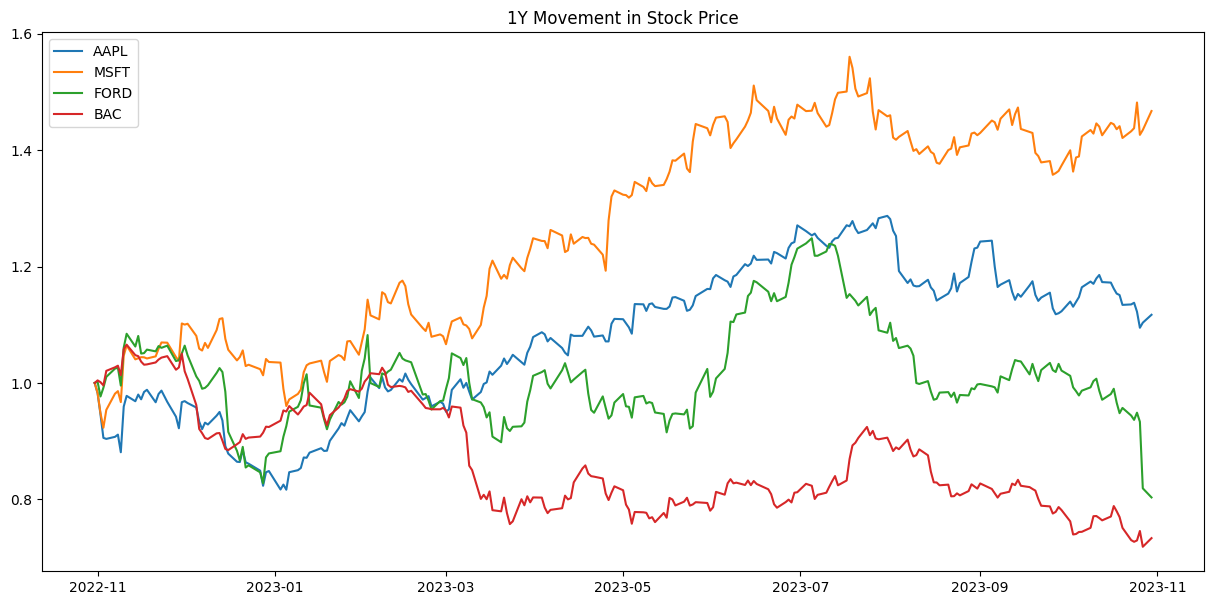

In [18]:
Stocks_change.plot(figsize=(15,7),
                   title="1Y Movement in Stock Price");

In [19]:
Stocks_dates = list(Stocks.index)
Stocks_dates

[datetime.date(2022, 10, 31),
 datetime.date(2022, 11, 1),
 datetime.date(2022, 11, 2),
 datetime.date(2022, 11, 3),
 datetime.date(2022, 11, 4),
 datetime.date(2022, 11, 7),
 datetime.date(2022, 11, 8),
 datetime.date(2022, 11, 9),
 datetime.date(2022, 11, 10),
 datetime.date(2022, 11, 11),
 datetime.date(2022, 11, 14),
 datetime.date(2022, 11, 15),
 datetime.date(2022, 11, 16),
 datetime.date(2022, 11, 17),
 datetime.date(2022, 11, 18),
 datetime.date(2022, 11, 21),
 datetime.date(2022, 11, 22),
 datetime.date(2022, 11, 23),
 datetime.date(2022, 11, 25),
 datetime.date(2022, 11, 28),
 datetime.date(2022, 11, 29),
 datetime.date(2022, 11, 30),
 datetime.date(2022, 12, 1),
 datetime.date(2022, 12, 2),
 datetime.date(2022, 12, 5),
 datetime.date(2022, 12, 6),
 datetime.date(2022, 12, 7),
 datetime.date(2022, 12, 8),
 datetime.date(2022, 12, 9),
 datetime.date(2022, 12, 12),
 datetime.date(2022, 12, 13),
 datetime.date(2022, 12, 14),
 datetime.date(2022, 12, 15),
 datetime.date(2022, 12,

In [20]:
curr_stocks_price = Stocks.iloc[-1].to_numpy()
curr_stocks_price

array([169.849197, 336.62677 ,   9.62    ,  25.486582])

In [21]:
stocks_total_value = stocks_notional * Stocks.shape[1]
stocks_total_value

4000000

In [22]:
# initial value of holdings
stocks_holdings_value = np.array([stocks_notional] * Stocks.shape[1])
stocks_holdings_value

array([1000000, 1000000, 1000000, 1000000])

# <a id = "p4">4.</a>  <font color = "green"> Check if the dates in Swaps and Stocks are the same </font>  [back to table of contents](#top)

In [23]:
Missing_SOFR_dates = list(set(Stocks_dates) - set(SOFR_dates))
Missing_SOFR_dates

[datetime.date(2023, 10, 9), datetime.date(2022, 11, 11)]

In [24]:
Missing_Stock_dates = list(set(SOFR_dates) - set(Stocks_dates))
Missing_Stock_dates

[datetime.date(2023, 6, 19), datetime.date(2023, 4, 7)]

# <a id = "p5">5.</a>  <font color = "green"> Combine the Swaps and Stocks Data </font>  [back to table of contents](#top)

In [25]:
d1 = [ d.toordinal()  for d in SOFR.index.tolist()]
p1 = SOFR['1Y'].tolist()
interp1 =  scipy.interpolate.interp1d(d1, p1)

d2 = [ d.toordinal()  for d in SOFR.index.tolist()]
p2 = SOFR['2Y'].tolist()
interp2 =  scipy.interpolate.interp1d(d2, p2)

d3 = [ d.toordinal()  for d in SOFR.index.tolist()]
p3 = SOFR['3Y'].tolist()
interp3 =  scipy.interpolate.interp1d(d3, p3)

d4 = [ d.toordinal()  for d in SOFR.index.tolist()]
p4 = SOFR['4Y'].tolist()
interp4 =  scipy.interpolate.interp1d(d4, p4)

d5 = [ d.toordinal()  for d in SOFR.index.tolist()]
p5 = SOFR['5Y'].tolist()
interp5 =  scipy.interpolate.interp1d(d5, p5)

d6 = [ d.toordinal()  for d in SOFR.index.tolist()]
p6 = SOFR['6Y'].tolist()
interp6 =  scipy.interpolate.interp1d(d6, p6)

d7 = [ d.toordinal()  for d in SOFR.index.tolist()]
p7 = SOFR['7Y'].tolist()
interp7 =  scipy.interpolate.interp1d(d7, p7)

d8 = [ d.toordinal()  for d in SOFR.index.tolist()]
p8 = SOFR['8Y'].tolist()
interp8 =  scipy.interpolate.interp1d(d8, p8)

d9 = [ d.toordinal()  for d in SOFR.index.tolist()]
p9 = SOFR['9Y'].tolist()
interp9 =  scipy.interpolate.interp1d(d9, p9)

d10 = [ d.toordinal()  for d in SOFR.index.tolist()]
p10 = SOFR['10Y'].tolist()
interp10 =  scipy.interpolate.interp1d(d10, p10)

d_AAPL = [ d.toordinal()  for d in Stocks.index.tolist()]
p_AAPL = Stocks['AAPL'].tolist()
interp_AAPL =  scipy.interpolate.interp1d(d_AAPL, p_AAPL)

d_MSFT = [ d.toordinal()  for d in Stocks.index.tolist()]
p_MSFT = Stocks['MSFT'].tolist()
interp_MSFT =  scipy.interpolate.interp1d(d_MSFT, p_MSFT)

d_FORD = [ d.toordinal()  for d in Stocks.index.tolist()]
p_FORD = Stocks['FORD'].tolist()
interp_FORD =  scipy.interpolate.interp1d(d_FORD, p_FORD)

d_BAC = [ d.toordinal()  for d in Stocks.index.tolist()]
p_BAC = Stocks['BAC'].tolist()
interp_BAC =  scipy.interpolate.interp1d(d_BAC, p_BAC)

dlist = list(set(d1) | set(d2) | set(d3) | set(d4) | set(d5)| set(d6)| set(d7)| set(d8)| set(d9)| set(d10)| set(d_AAPL)| set(d_MSFT)| set(d_FORD)| set(d_BAC))

In [26]:
len(dlist)

253

In [27]:
# Calculate the levels (not change) using interpolation

numchg = len(dlist)
AAPL_interpolated = [ interp_AAPL(dlist[i]).flat[0] for i in range(numchg) ]
MSFT_interpolated = [ interp_MSFT(dlist[i]).flat[0] for i in range(numchg) ]
FORD_interpolated = [ interp_FORD(dlist[i]).flat[0] for i in range(numchg) ]
BAC_interpolated = [ interp_BAC(dlist[i]).flat[0] for i in range(numchg) ]

Y1_interpolated = [ interp1(dlist[i]).flat[0] for i in range(numchg) ]
Y2_interpolated = [ interp2(dlist[i]).flat[0] for i in range(numchg) ]
Y3_interpolated = [ interp3(dlist[i]).flat[0] for i in range(numchg) ]
Y4_interpolated = [ interp4(dlist[i]).flat[0] for i in range(numchg) ]
Y5_interpolated = [ interp5(dlist[i]).flat[0] for i in range(numchg) ]
Y6_interpolated = [ interp6(dlist[i]).flat[0] for i in range(numchg) ]
Y7_interpolated = [ interp7(dlist[i]).flat[0] for i in range(numchg) ]
Y8_interpolated = [ interp8(dlist[i]).flat[0] for i in range(numchg) ]
Y9_interpolated = [ interp9(dlist[i]).flat[0] for i in range(numchg) ]
Y10_interpolated = [ interp10(dlist[i]).flat[0] for i in range(numchg) ]

In [28]:
# Note that this is using the interpolated data to calculate daily change (in percentage)

# numchg = len(dlist)-1
# AAPL_interpolated = [ interp_AAPL(dlist[i+1]).flat[0] / interp_AAPL(dlist[i]).flat[0] - 1.0  for i in range(numchg) ]
# MSFT_interpolated = [ interp_MSFT(dlist[i+1]).flat[0] / interp_MSFT(dlist[i]).flat[0] - 1.0  for i in range(numchg) ]
# FORD_interpolated = [ interp_FORD(dlist[i+1]).flat[0] / interp_FORD(dlist[i]).flat[0] - 1.0  for i in range(numchg) ]
# BAC_interpolated = [ interp_BAC(dlist[i+1]).flat[0] / interp_BAC(dlist[i]).flat[0] - 1.0  for i in range(numchg) ]

# Y1_interpolated = [ interp1(dlist[i+1]).flat[0] / interp1(dlist[i]).flat[0] - 1.0  for i in range(numchg) ]
# Y2_interpolated = [ interp2(dlist[i+1]).flat[0] / interp2(dlist[i]).flat[0] - 1.0  for i in range(numchg) ]
# Y3_interpolated = [ interp3(dlist[i+1]).flat[0] / interp3(dlist[i]).flat[0] - 1.0  for i in range(numchg) ]
# Y4_interpolated = [ interp4(dlist[i+1]).flat[0] / interp4(dlist[i]).flat[0] - 1.0  for i in range(numchg) ]
# Y5_interpolated = [ interp5(dlist[i+1]).flat[0] / interp5(dlist[i]).flat[0] - 1.0  for i in range(numchg) ]
# Y6_interpolated = [ interp6(dlist[i+1]).flat[0] / interp6(dlist[i]).flat[0] - 1.0  for i in range(numchg) ]
# Y7_interpolated = [ interp7(dlist[i+1]).flat[0] / interp7(dlist[i]).flat[0] - 1.0  for i in range(numchg) ]
# Y8_interpolated = [ interp8(dlist[i+1]).flat[0] / interp8(dlist[i]).flat[0] - 1.0  for i in range(numchg) ]
# Y9_interpolated = [ interp9(dlist[i+1]).flat[0] / interp9(dlist[i]).flat[0] - 1.0  for i in range(numchg) ]
# Y10_interpolated = [ interp10(dlist[i+1]).flat[0] / interp10(dlist[i]).flat[0] - 1.0  for i in range(numchg) ]

In [29]:
# Create a single dataframe with the interpolated data

alldata = {'AAPL' : AAPL_interpolated,
           'MSFT' : MSFT_interpolated,
           'FORD' : FORD_interpolated ,
           'BAC' : BAC_interpolated,
           '1Y' : Y1_interpolated,
           '2Y' : Y2_interpolated,
           '3Y' : Y3_interpolated,
           '4Y' : Y4_interpolated,
           '5Y' : Y5_interpolated,
           '6Y' : Y6_interpolated,
           '7Y' : Y7_interpolated,
           '8Y' : Y8_interpolated,
           '9Y' : Y9_interpolated,
           '10Y' : Y10_interpolated}

df_all = pd.DataFrame(alldata, 
                      columns=['AAPL', 
                               'MSFT', 
                               'FORD', 
                               'BAC', 
                               '1Y', 
                               '2Y', 
                               '3Y', 
                               '4Y', 
                               '5Y', 
                               '6Y', 
                               '7Y', 
                               '8Y', 
                               '9Y', 
                               '10Y'])

In [30]:
df_all

,AAPL,MSFT,FORD,BAC,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y
0,152.041122,229.443207,11.974380,34.748581,0.046449,0.044583,0.042002,0.040318,0.039297,0.038534,0.037979,0.037648,0.037465,0.037353
1,149.373917,225.529037,12.001248,34.902847,0.046970,0.045022,0.042344,0.040614,0.039522,0.038658,0.038007,0.037605,0.037368,0.037209
2,143.801514,217.552444,11.696740,34.796783,0.047203,0.045496,0.042749,0.040868,0.039675,0.038776,0.038117,0.037704,0.037458,0.037300
3,137.703613,211.770157,11.875863,34.603954,0.047894,0.046594,0.043833,0.041825,0.040507,0.039537,0.038820,0.038328,0.038002,0.037796
4,137.435455,218.827515,12.099767,35.471703,0.047500,0.046097,0.043385,0.041503,0.040303,0.039421,0.038782,0.038373,0.038128,0.037988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,172.991058,329.860504,11.215128,25.268324,0.052503,0.048399,0.045999,0.044850,0.044305,0.044036,0.043889,0.043816,0.043798,0.043826
249,170.657135,339.979980,11.362824,25.347691,0.052653,0.048791,0.046595,0.045594,0.045200,0.045017,0.044911,0.044867,0.044876,0.044926
250,166.458023,327.225861,11.175742,25.913177,0.052243,0.048044,0.045645,0.044538,0.044086,0.043893,0.043808,0.043795,0.043829,0.043898
251,167.784576,329.141968,9.807083,24.970699,0.052115,0.047758,0.045284,0.044200,0.043762,0.043636,0.043643,0.043702,0.043793,0.043908


# <a id = "p6">6.</a>  <font color = "green"> Convert from swap rates to discount factors </font>  [back to table of contents](#top)

In [31]:
# Get only the swap rates

DF = df_all.iloc[:,4:].copy()
DF

,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y
0,0.046449,0.044583,0.042002,0.040318,0.039297,0.038534,0.037979,0.037648,0.037465,0.037353
1,0.046970,0.045022,0.042344,0.040614,0.039522,0.038658,0.038007,0.037605,0.037368,0.037209
2,0.047203,0.045496,0.042749,0.040868,0.039675,0.038776,0.038117,0.037704,0.037458,0.037300
3,0.047894,0.046594,0.043833,0.041825,0.040507,0.039537,0.038820,0.038328,0.038002,0.037796
4,0.047500,0.046097,0.043385,0.041503,0.040303,0.039421,0.038782,0.038373,0.038128,0.037988
...,...,...,...,...,...,...,...,...,...,...
248,0.052503,0.048399,0.045999,0.044850,0.044305,0.044036,0.043889,0.043816,0.043798,0.043826
249,0.052653,0.048791,0.046595,0.045594,0.045200,0.045017,0.044911,0.044867,0.044876,0.044926
250,0.052243,0.048044,0.045645,0.044538,0.044086,0.043893,0.043808,0.043795,0.043829,0.043898
251,0.052115,0.047758,0.045284,0.044200,0.043762,0.043636,0.043643,0.043702,0.043793,0.043908


In [32]:
# Compute discount factors from the zero rates
# See QF605 Session 1 Slide 4
for i in range(len(DF.columns)):
    DF[DF.columns[i]] = np.exp(- DF[DF.columns[i]].astype(float) * (i + 1))

In [33]:
DF

,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y
0,0.954613,0.914694,0.881609,0.851061,0.821614,0.793577,0.766553,0.739942,0.713778,0.688304
1,0.954116,0.913891,0.880705,0.850053,0.820689,0.792987,0.766399,0.740196,0.714403,0.689294
2,0.953893,0.913025,0.879637,0.849189,0.820063,0.792425,0.765814,0.739612,0.713825,0.688664
3,0.953235,0.911023,0.876780,0.845945,0.816658,0.788816,0.762050,0.735930,0.710334,0.685261
4,0.953611,0.911928,0.877959,0.847037,0.817491,0.789363,0.762252,0.735662,0.709530,0.683946
...,...,...,...,...,...,...,...,...,...,...
248,0.948851,0.907740,0.871102,0.835770,0.801294,0.767810,0.735488,0.704315,0.674231,0.645160
249,0.948709,0.907028,0.869546,0.833289,0.797719,0.763303,0.730246,0.698417,0.667725,0.638101
250,0.949098,0.908384,0.872027,0.836814,0.802175,0.768469,0.735902,0.704436,0.674042,0.644694
251,0.949220,0.908905,0.872971,0.837948,0.803475,0.769654,0.736756,0.704958,0.674264,0.644626


In [34]:
# Get the discount factors for today
today_DF = DF.iloc[-1, ].to_numpy()
today_DF

array([0.94909668, 0.90863809, 0.87259128, 0.83746233, 0.80280786,
       0.76892333, 0.7360513 , 0.70424673, 0.6735244 , 0.64388735])

In [35]:
# See QF605 Session 2 Slide 31
def PV_payer_swap(discount_factors):
    float_leg =  (1 - discount_factors[9])                    # 1 - Last discount factor
    fix_leg = 1*fixed_leg_interest * discount_factors.sum()   # Sum of discount factors multiplied by fixed leg multiplied by duratin between payments (1 year in this case)
    payer_swap_PV  = swap_notional * (float_leg - fix_leg)

    return payer_swap_PV

In [36]:
# Compute the current value of the swap

payer_swap_today = PV_payer_swap(today_DF)
payer_swap_today

2442901.9998463253

# <a id = "p7">7.</a>  <font color = "green"> Calculate PV01 </font>  [back to table of contents](#top)

In [37]:
n_tenors = len(SOFR.columns)
n_tenors

10

In [38]:
PV01 = np.zeros(n_tenors)
PV01

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [39]:
# Filter for rates today
sofr_today = SOFR.iloc[-1, ].to_numpy()
sofr_today

array([0.0522446062245015, 0.0479042005661318, 0.0454293376025913,
       0.0443447502563426, 0.0439279746825301, 0.043794001970382,
       0.0437793521534213, 0.0438283144768502, 0.0439145618623502,
       0.044023149444895], dtype=object)

In [40]:
# For each tenor in all the tenors chosen
for tenor in range(n_tenors):

    # Set up a dummy array to store all the adjusted SOFR rates
    pv01_sofr = np.zeros(len(sofr_today))

    # Add 1bp to the rate for that tenor, keeping the rates for all the other tenors constant
    for j in range(n_tenors):
        if j == tenor:
            pv01_sofr[j] = sofr_today[j] + bp_change  # Add 1 bp to the rate of that tenor
        else:
            pv01_sofr[j] = sofr_today[j]              # Keep the rate unchanged

    # Set up a dummy dataframe to store the adjusted discount factors
    new_DF = np.zeros(len(pv01_sofr))

    # Compute new discount factors
    for i in range(len(pv01_sofr)):
        new_DF[i] = np.exp(- pv01_sofr[i] * (i + 1))

    # Compute PV01 change in swap value
    PV01[tenor] = (PV_payer_swap(new_DF) - payer_swap_today) / bp_change

In [41]:
PV01

array([3.98600677e+06, 7.63179678e+06, 1.09930011e+07, 1.40665536e+07,
       1.68547510e+07, 1.93710561e+07, 2.16323359e+07, 2.36532276e+07,
       2.54477691e+07, 6.70595263e+08])

# <a id = "p8">8.</a>  <font color = "green"> Calculate mean vector and covariance matrix </font>  [back to table of contents](#top)

In [42]:
# Calculate the daily change in stocks (in percentage)

df_all_stocks_delta = df_all.iloc[:,:4]/df_all.iloc[:,:4].shift(1) - 1
df_all_stocks_delta.dropna(inplace=True)
df_all_stocks_delta

,AAPL,MSFT,FORD,BAC
1,-0.017543,-0.017059,0.002244,0.004439
2,-0.037305,-0.035368,-0.025373,-0.003039
3,-0.042405,-0.026579,0.015314,-0.005542
4,-0.001947,0.033326,0.018854,0.025077
5,0.003902,0.029270,0.014064,0.005980
...,...,...,...,...
248,0.002543,0.003674,-0.007840,-0.003911
249,-0.013492,0.030678,0.013169,0.003141
250,-0.024606,-0.037514,-0.016464,0.022309
251,0.007969,0.005856,-0.122467,-0.036371


In [43]:
# Calculate the daily change in swap rates (just subtract today's swap rates with yesterday's swap rates)

df_all_swaps_delta = df_all.iloc[:,4:] - df_all.iloc[:,4:].shift(1)
df_all_swaps_delta.dropna(inplace=True)
df_all_swaps_delta

,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y
1,0.000521,0.000439,0.000342,0.000296,0.000225,0.000124,0.000029,-0.000043,-9.724439e-05,-0.000144
2,0.000234,0.000474,0.000404,0.000254,0.000153,0.000118,0.000109,0.000099,8.994989e-05,0.000091
3,0.000690,0.001098,0.001085,0.000957,0.000832,0.000761,0.000704,0.000624,5.446595e-04,0.000495
4,-0.000394,-0.000497,-0.000448,-0.000322,-0.000204,-0.000116,-0.000038,0.000045,1.258218e-04,0.000192
5,0.000429,0.000536,0.000499,0.000413,0.000332,0.000313,0.000328,0.000342,3.452884e-04,0.000339
...,...,...,...,...,...,...,...,...,...,...
248,0.000114,0.000371,0.000417,0.000343,0.000257,0.000165,0.000083,0.000032,2.757643e-07,-0.000027
249,0.000150,0.000393,0.000596,0.000743,0.000894,0.000981,0.001022,0.001051,1.077486e-03,0.001100
250,-0.000410,-0.000747,-0.000950,-0.001055,-0.001114,-0.001124,-0.001102,-0.001073,-1.046232e-03,-0.001028
251,-0.000129,-0.000286,-0.000361,-0.000339,-0.000324,-0.000257,-0.000166,-0.000093,-3.667796e-05,0.000011


In [44]:
# Combine the 2 dataframes

df_all_delta = pd.merge(left=df_all_stocks_delta, 
                        right=df_all_swaps_delta,
                        how="inner",
                        left_index=True,
                        right_index=True)

df_all_delta.dropna(inplace=True)
df_all_delta

,AAPL,MSFT,FORD,BAC,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y
1,-0.017543,-0.017059,0.002244,0.004439,0.000521,0.000439,0.000342,0.000296,0.000225,0.000124,0.000029,-0.000043,-9.724439e-05,-0.000144
2,-0.037305,-0.035368,-0.025373,-0.003039,0.000234,0.000474,0.000404,0.000254,0.000153,0.000118,0.000109,0.000099,8.994989e-05,0.000091
3,-0.042405,-0.026579,0.015314,-0.005542,0.000690,0.001098,0.001085,0.000957,0.000832,0.000761,0.000704,0.000624,5.446595e-04,0.000495
4,-0.001947,0.033326,0.018854,0.025077,-0.000394,-0.000497,-0.000448,-0.000322,-0.000204,-0.000116,-0.000038,0.000045,1.258218e-04,0.000192
5,0.003902,0.029270,0.014064,0.005980,0.000429,0.000536,0.000499,0.000413,0.000332,0.000313,0.000328,0.000342,3.452884e-04,0.000339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,0.002543,0.003674,-0.007840,-0.003911,0.000114,0.000371,0.000417,0.000343,0.000257,0.000165,0.000083,0.000032,2.757643e-07,-0.000027
249,-0.013492,0.030678,0.013169,0.003141,0.000150,0.000393,0.000596,0.000743,0.000894,0.000981,0.001022,0.001051,1.077486e-03,0.001100
250,-0.024606,-0.037514,-0.016464,0.022309,-0.000410,-0.000747,-0.000950,-0.001055,-0.001114,-0.001124,-0.001102,-0.001073,-1.046232e-03,-0.001028
251,0.007969,0.005856,-0.122467,-0.036371,-0.000129,-0.000286,-0.000361,-0.000339,-0.000324,-0.000257,-0.000166,-0.000093,-3.667796e-05,0.000011


In [45]:
# Calculate the average daily change

AAPL_daily_return = df_all_delta["AAPL"].mean(axis=0)
MSFT_daily_return = df_all_delta["MSFT"].mean(axis=0)
FORD_daily_return = df_all_delta["FORD"].mean(axis=0)
BAC_daily_return = df_all_delta["BAC"].mean(axis=0)
Y1_daily_return = df_all_delta["1Y"].mean(axis=0)
Y2_daily_return = df_all_delta["2Y"].mean(axis=0)
Y3_daily_return = df_all_delta["3Y"].mean(axis=0)
Y4_daily_return = df_all_delta["4Y"].mean(axis=0)
Y5_daily_return = df_all_delta["5Y"].mean(axis=0)
Y6_daily_return = df_all_delta["6Y"].mean(axis=0)
Y7_daily_return = df_all_delta["7Y"].mean(axis=0)
Y8_daily_return = df_all_delta["8Y"].mean(axis=0)
Y9_daily_return = df_all_delta["9Y"].mean(axis=0)
Y10_daily_return = df_all_delta["10Y"].mean(axis=0)

In [46]:
# Calculate the standard deviation of daily change

AAPL_daily_std = df_all_delta["AAPL"].std(axis=0)
MSFT_daily_std = df_all_delta["MSFT"].std(axis=0)
FORD_daily_std = df_all_delta["FORD"].std(axis=0)
BAC_daily_std = df_all_delta["BAC"].std(axis=0)
Y1_daily_std = df_all_delta["1Y"].std(axis=0)
Y2_daily_std = df_all_delta["2Y"].std(axis=0)
Y3_daily_std = df_all_delta["3Y"].std(axis=0)
Y4_daily_std = df_all_delta["4Y"].std(axis=0)
Y5_daily_std = df_all_delta["5Y"].std(axis=0)
Y6_daily_std = df_all_delta["6Y"].std(axis=0)
Y7_daily_std = df_all_delta["7Y"].std(axis=0)
Y8_daily_std = df_all_delta["8Y"].std(axis=0)
Y9_daily_std = df_all_delta["9Y"].std(axis=0)
Y10_daily_std = df_all_delta["10Y"].std(axis=0)

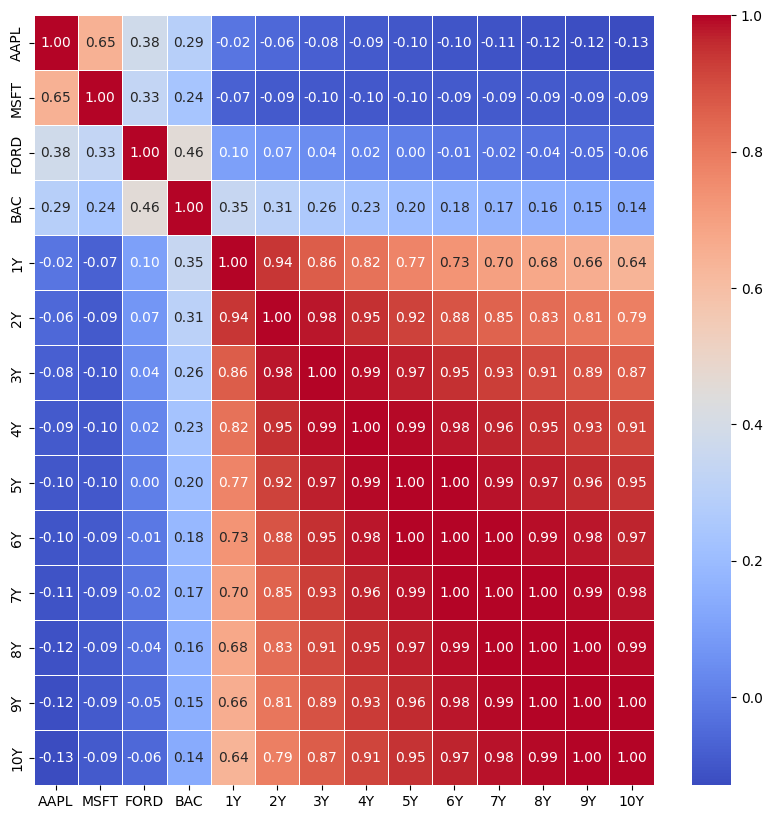

In [47]:
# Calculate the correlation matrix

corr_mat = df_all_delta.corr()

# Set figure size before calling sns.heatmap
plt.figure(figsize=(10, 10))  # Set figure size

sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()

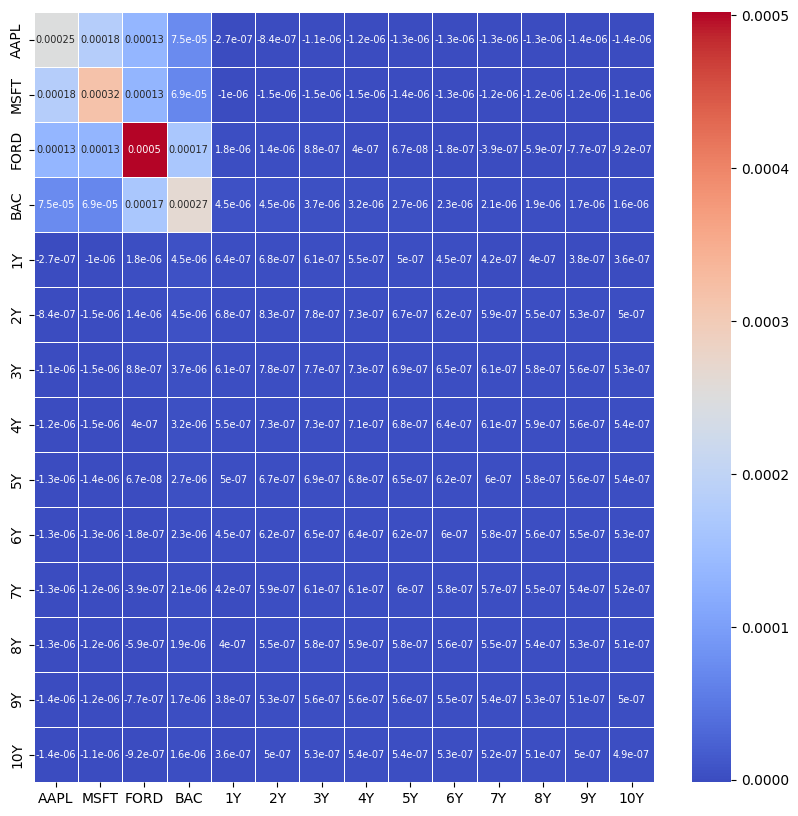

In [48]:
# Calculate the covariance matrix

cov_mat = df_all_delta.cov()

# Set figure size before calling sns.heatmap
plt.figure(figsize=(10, 10))  # Set figure size

sns.heatmap(cov_mat, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 7})
plt.show()

In [49]:
df_all_delta.mean(axis=0)

AAPL    0.000563
MSFT    0.001679
FORD   -0.000615
BAC    -0.001096
1Y      0.000023
2Y      0.000013
3Y      0.000014
4Y      0.000016
5Y      0.000018
6Y      0.000021
7Y      0.000023
8Y      0.000025
9Y      0.000026
10Y     0.000026
dtype: float64

In [50]:
mean_vec = np.array(df_all_delta.mean(axis=0))
mean_vec

array([ 5.63296803e-04,  1.67861201e-03, -6.14862797e-04, -1.09642566e-03,
        2.29992749e-05,  1.31798245e-05,  1.35998572e-05,  1.59800247e-05,
        1.83773538e-05,  2.08728864e-05,  2.30179242e-05,  2.45253351e-05,
        2.55942213e-05,  2.64707921e-05])

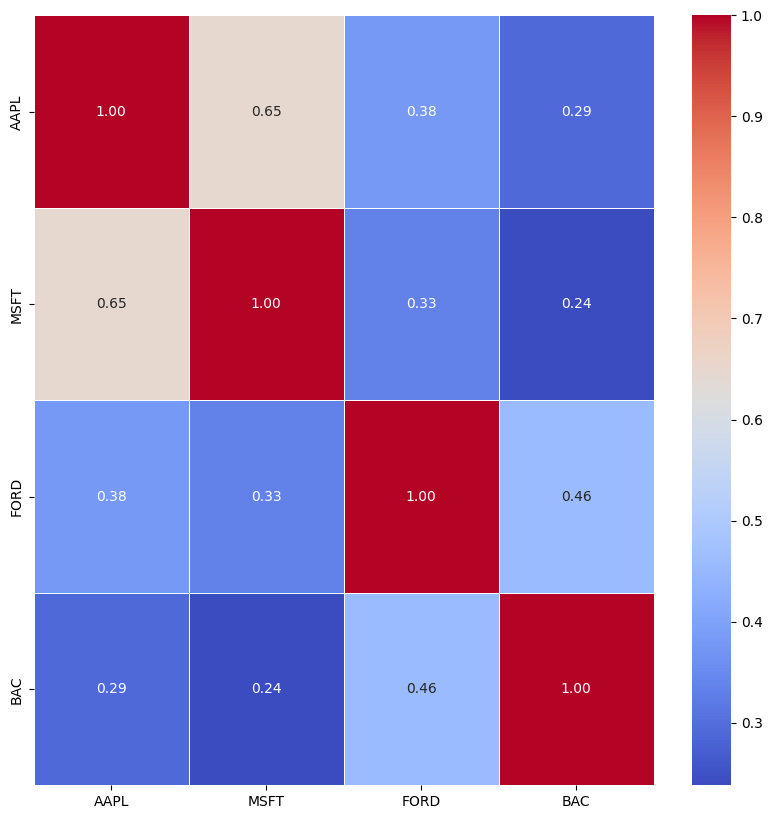

In [51]:
# Calculate the correlation matrix

stocks_only_corr_mat = df_all_stocks_delta.corr()

# Set figure size before calling sns.heatmap
plt.figure(figsize=(10, 10))  # Set figure size

sns.heatmap(stocks_only_corr_mat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()

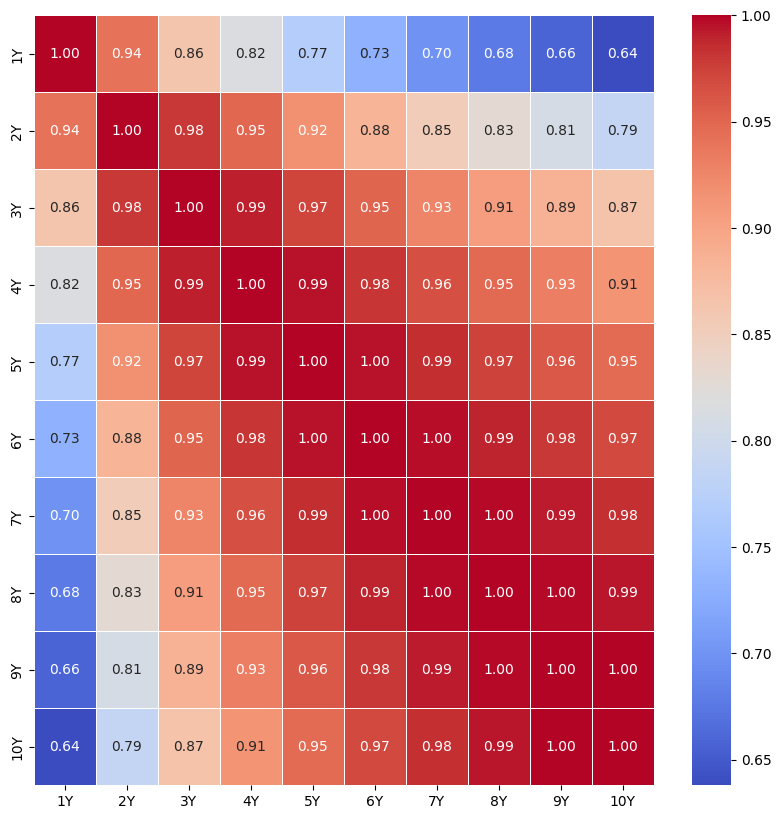

In [52]:
# Calculate the correlation matrix

swaps_only_corr_mat = df_all_swaps_delta.corr()

# Set figure size before calling sns.heatmap
plt.figure(figsize=(10, 10))  # Set figure size

sns.heatmap(swaps_only_corr_mat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()

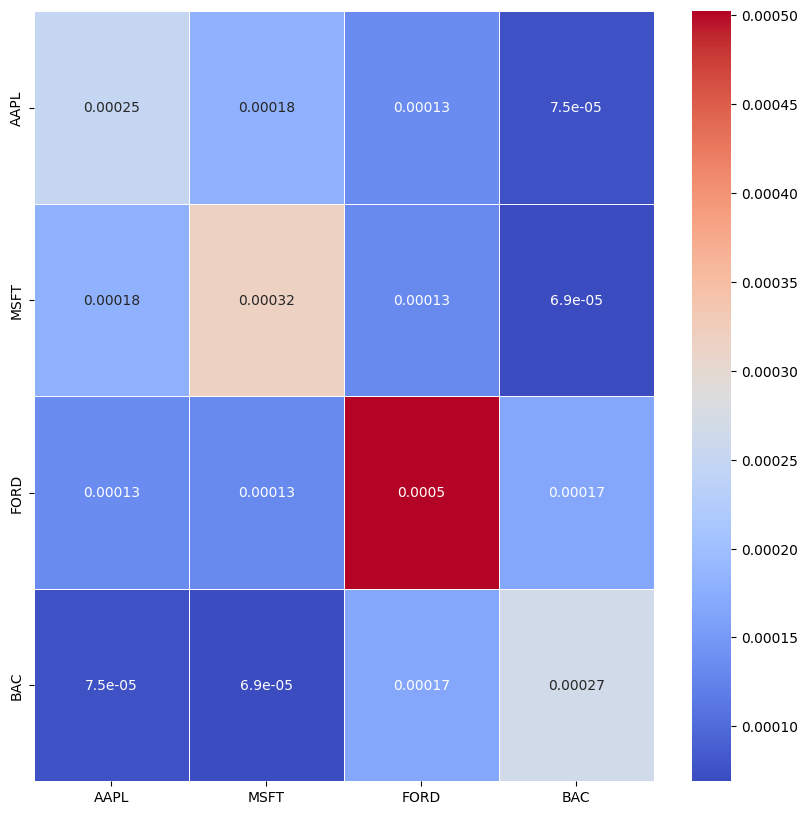

In [53]:
# Calculate the stocks only covariance matrix

stocks_only_cov_mat = df_all_stocks_delta.cov()

# Set figure size before calling sns.heatmap
plt.figure(figsize=(10, 10))  # Set figure size

sns.heatmap(stocks_only_cov_mat, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

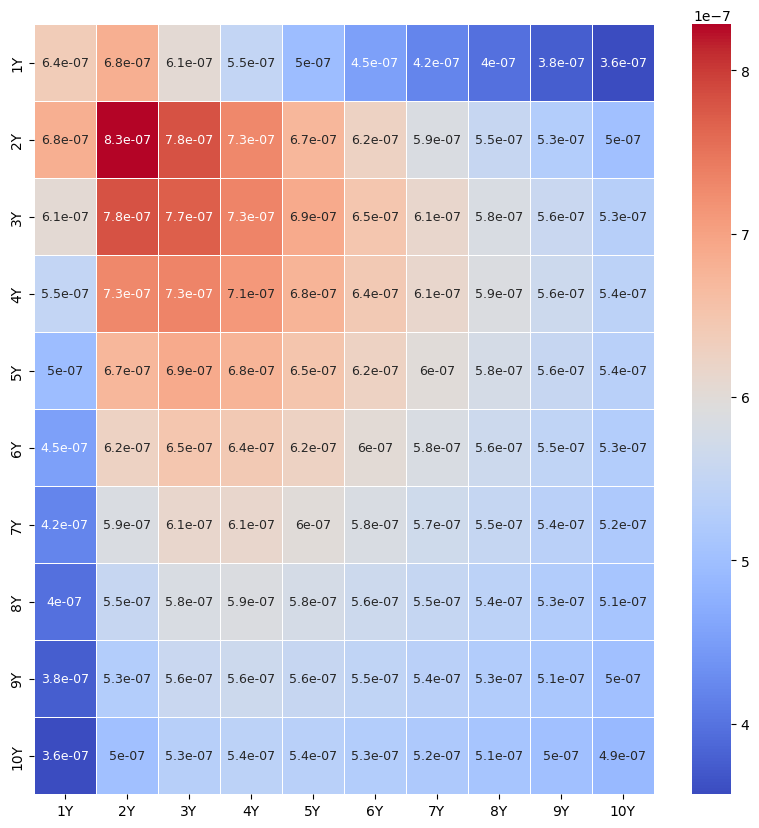

In [54]:
# Calculate the swaps only covariance matrix

swaps_only_cov_mat = df_all_swaps_delta.cov()

# Set figure size before calling sns.heatmap
plt.figure(figsize=(10, 10))  # Set figure size

sns.heatmap(swaps_only_cov_mat, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 9})
plt.show()

In [55]:
stocks_only_mean_vec = np.array(df_all_delta.iloc[:,:4].mean(axis=0))
stocks_only_mean_vec

array([ 0.0005633 ,  0.00167861, -0.00061486, -0.00109643])

In [56]:
swaps_only_mean_vec = np.array(df_all_delta.iloc[:,4:].mean(axis=0))
swaps_only_mean_vec

array([2.29992749e-05, 1.31798245e-05, 1.35998572e-05, 1.59800247e-05,
       1.83773538e-05, 2.08728864e-05, 2.30179242e-05, 2.45253351e-05,
       2.55942213e-05, 2.64707921e-05])

# <a id = "p9">9.</a>  <font color = "green"> Parametric VaR Model </font>  [back to table of contents](#top)

In [57]:
# z value
z = norm.ppf(VaR_percentile / 100)
z

-1.6448536269514729

In [58]:
mean_vec

array([ 5.63296803e-04,  1.67861201e-03, -6.14862797e-04, -1.09642566e-03,
        2.29992749e-05,  1.31798245e-05,  1.35998572e-05,  1.59800247e-05,
        1.83773538e-05,  2.08728864e-05,  2.30179242e-05,  2.45253351e-05,
        2.55942213e-05,  2.64707921e-05])

In [59]:
cov_mat

,AAPL,MSFT,FORD,BAC,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y
AAPL,2.496067e-04,0.000182,1.344972e-04,0.000075,-2.720645e-07,-8.437884e-07,-1.111229e-06,-1.216077e-06,-1.257167e-06,-1.264297e-06,-1.281086e-06,-1.334470e-06,-1.396828e-06,-1.432367e-06
MSFT,1.818089e-04,0.000317,1.330176e-04,0.000069,-1.031281e-06,-1.492356e-06,-1.535778e-06,-1.470557e-06,-1.365721e-06,-1.281011e-06,-1.223910e-06,-1.192920e-06,-1.173816e-06,-1.146740e-06
FORD,1.344972e-04,0.000133,5.021063e-04,0.000167,1.798906e-06,1.443075e-06,8.823550e-07,4.017554e-07,6.699575e-08,-1.837672e-07,-3.908341e-07,-5.884424e-07,-7.716733e-07,-9.204329e-07
BAC,7.480110e-05,0.000069,1.666781e-04,0.000266,4.506189e-06,4.539855e-06,3.729015e-06,3.167829e-06,2.685086e-06,2.332503e-06,2.089312e-06,1.903967e-06,1.745986e-06,1.591907e-06
1Y,-2.720645e-07,-0.000001,1.798906e-06,0.000005,6.371052e-07,6.839538e-07,6.051949e-07,5.491190e-07,4.964127e-07,4.531509e-07,4.210178e-07,3.966976e-07,3.763323e-07,3.568566e-07
2Y,-8.437884e-07,-0.000001,1.443075e-06,0.000005,6.839538e-07,8.280739e-07,7.818156e-07,7.288812e-07,6.731247e-07,6.245761e-07,5.858837e-07,5.544902e-07,5.272400e-07,5.017767e-07
3Y,-1.111229e-06,-0.000002,8.823550e-07,0.000004,6.051949e-07,7.818156e-07,7.698051e-07,7.329377e-07,6.886274e-07,6.478278e-07,6.133342e-07,5.838989e-07,5.575935e-07,5.330539e-07
4Y,-1.216077e-06,-0.000001,4.017554e-07,0.000003,5.491190e-07,7.288812e-07,7.329377e-07,7.112516e-07,6.766293e-07,6.426581e-07,6.132247e-07,5.871304e-07,5.631621e-07,5.405947e-07
5Y,-1.257167e-06,-0.000001,6.699575e-08,0.000003,4.964127e-07,6.731247e-07,6.886274e-07,6.766293e-07,6.509800e-07,6.238474e-07,5.991406e-07,5.765032e-07,5.552734e-07,5.350883e-07
6Y,-1.264297e-06,-0.000001,-1.837672e-07,0.000002,4.531509e-07,6.245761e-07,6.478278e-07,6.426581e-07,6.238474e-07,6.030772e-07,5.833329e-07,5.641475e-07,5.454403e-07,5.274215e-07


In [60]:
# Weight vector
w_parametric = np.concatenate((stocks_holdings_value, PV01), axis=0)
w_parametric

array([1.00000000e+06, 1.00000000e+06, 1.00000000e+06, 1.00000000e+06,
       3.98600677e+06, 7.63179678e+06, 1.09930011e+07, 1.40665536e+07,
       1.68547510e+07, 1.93710561e+07, 2.16323359e+07, 2.36532276e+07,
       2.54477691e+07, 6.70595263e+08])

In [61]:
# Calculating mean, variance and 5-percentile for 1 day
m1d =  np.inner(w_parametric, mean_vec)
v1d = np.inner(np.dot(w_parametric, cov_mat), w_parametric)
var1d = np.abs(stat.norm.ppf(VaR_percentile/100, loc=m1d, scale=np.sqrt(v1d)))

In [62]:
VaR_percentile/100

0.05

In [63]:
m1d

21291.782469699254

In [64]:
v1d

332472753361.1178

In [65]:
np.sqrt(v1d)

576604.5034173058

In [66]:
var1d

927138.226292809

In [67]:
print("")
print("")
print("============================================================================================================================")
print(f"Parametric VaR [1d, 95%]: {var1d:,.0f}")
print(f"Mean {m1d:,.2f}, Variance:  {v1d:,.2f}, SD:{np.sqrt(v1d):,.2f}")
print("============================================================================================================================")



Parametric VaR [1d, 95%]: 927,138
Mean 21,291.78, Variance:  332,472,753,361.12, SD:576,604.50


### <a id = "p9a">9a.</a>  <font color = "green"> Stocks Only Parametric VaR Model </font>  [back to table of contents](#top)

In [68]:
stocks_only_mean_vec

array([ 0.0005633 ,  0.00167861, -0.00061486, -0.00109643])

In [69]:
stocks_only_cov_mat

,AAPL,MSFT,FORD,BAC
AAPL,0.000250,0.000182,0.000134,0.000075
MSFT,0.000182,0.000317,0.000133,0.000069
FORD,0.000134,0.000133,0.000502,0.000167
BAC,0.000075,0.000069,0.000167,0.000266


In [70]:
# Stocks weight vector
stocks_only_w_parametric = stocks_holdings_value
stocks_only_w_parametric

array([1000000, 1000000, 1000000, 1000000])

In [71]:
# Calculating mean, variance and 5-percentile for 1 day
stocks_only_m1d =  np.inner(stocks_only_w_parametric, stocks_only_mean_vec)
stocks_only_v1d = np.inner(np.dot(stocks_only_w_parametric, stocks_only_cov_mat), stocks_only_w_parametric)
stocks_only_var1d = np.abs(stat.norm.ppf(VaR_percentile/100, loc=stocks_only_m1d, scale=np.sqrt(stocks_only_v1d)))

In [72]:
print("")
print("")
print("============================================================================================================================")
print(f"Stocks Only Parametric VaR [1d, 95%]: {stocks_only_var1d:,.0f}")
print(f"Mean {stocks_only_m1d:,.2f}, Variance:  {v1d:,.2f}, SD:{np.sqrt(stocks_only_v1d):,.2f}")
print("============================================================================================================================")



Stocks Only Parametric VaR [1d, 95%]: 87,349
Mean 530.62, Variance:  332,472,753,361.12, SD:53,427.18


### <a id = "p9b">9b.</a>  <font color = "green"> Swaps Only Parametric VaR Model </font>  [back to table of contents](#top)

In [73]:
swaps_only_mean_vec

array([2.29992749e-05, 1.31798245e-05, 1.35998572e-05, 1.59800247e-05,
       1.83773538e-05, 2.08728864e-05, 2.30179242e-05, 2.45253351e-05,
       2.55942213e-05, 2.64707921e-05])

In [74]:
swaps_only_cov_mat

,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y
1Y,6.371052e-07,6.839538e-07,6.051949e-07,5.491190e-07,4.964127e-07,4.531509e-07,4.210178e-07,3.966976e-07,3.763323e-07,3.568566e-07
2Y,6.839538e-07,8.280739e-07,7.818156e-07,7.288812e-07,6.731247e-07,6.245761e-07,5.858837e-07,5.544902e-07,5.272400e-07,5.017767e-07
3Y,6.051949e-07,7.818156e-07,7.698051e-07,7.329377e-07,6.886274e-07,6.478278e-07,6.133342e-07,5.838989e-07,5.575935e-07,5.330539e-07
4Y,5.491190e-07,7.288812e-07,7.329377e-07,7.112516e-07,6.766293e-07,6.426581e-07,6.132247e-07,5.871304e-07,5.631621e-07,5.405947e-07
5Y,4.964127e-07,6.731247e-07,6.886274e-07,6.766293e-07,6.509800e-07,6.238474e-07,5.991406e-07,5.765032e-07,5.552734e-07,5.350883e-07
6Y,4.531509e-07,6.245761e-07,6.478278e-07,6.426581e-07,6.238474e-07,6.030772e-07,5.833329e-07,5.641475e-07,5.454403e-07,5.274215e-07
7Y,4.210178e-07,5.858837e-07,6.133342e-07,6.132247e-07,5.991406e-07,5.833329e-07,5.680359e-07,5.521185e-07,5.358261e-07,5.198002e-07
8Y,3.966976e-07,5.544902e-07,5.838989e-07,5.871304e-07,5.765032e-07,5.641475e-07,5.521185e-07,5.391255e-07,5.253254e-07,5.112911e-07
9Y,3.763323e-07,5.272400e-07,5.575935e-07,5.631621e-07,5.552734e-07,5.454403e-07,5.358261e-07,5.253254e-07,5.138576e-07,5.017119e-07
10Y,3.568566e-07,5.017767e-07,5.330539e-07,5.405947e-07,5.350883e-07,5.274215e-07,5.198002e-07,5.112911e-07,5.017119e-07,4.912058e-07


In [75]:
# Swaps weight vector
swaps_only_w_parametric = PV01
swaps_only_w_parametric

array([3.98600677e+06, 7.63179678e+06, 1.09930011e+07, 1.40665536e+07,
       1.68547510e+07, 1.93710561e+07, 2.16323359e+07, 2.36532276e+07,
       2.54477691e+07, 6.70595263e+08])

In [76]:
# Calculating mean, variance and 5-percentile for 1 day
swaps_only_m1d =  np.inner(swaps_only_w_parametric, swaps_only_mean_vec)
swaps_only_v1d = np.inner(np.dot(swaps_only_w_parametric, swaps_only_cov_mat), swaps_only_w_parametric)
swaps_only_var1d = np.abs(stat.norm.ppf(VaR_percentile/100, loc=swaps_only_m1d, scale=np.sqrt(swaps_only_v1d)))

In [77]:
print("")
print("")
print("============================================================================================================================")
print(f"Swaps Only Parametric VaR [1d, 95%]: {swaps_only_var1d:,.0f}")
print(f"Mean {swaps_only_m1d:,.2f}, Variance:  {v1d:,.2f}, SD:{np.sqrt(swaps_only_v1d):,.2f}")
print("============================================================================================================================")



Swaps Only Parametric VaR [1d, 95%]: 927,276
Mean 20,761.16, Variance:  332,472,753,361.12, SD:576,365.94


# <a id = "p10">10.</a>  <font color = "green"> Monte Carlo VaR Model </font>  [back to table of contents](#top)

In [78]:
# Full revaluation 1d pnl evaluation

def pnl1d_full(AAPL_daily_return, 
               MSFT_daily_return, 
               FORD_daily_return,
               BAC_daily_return,
               Y1_daily_return,
               Y2_daily_return,
               Y3_daily_return,
               Y4_daily_return,
               Y5_daily_return,
               Y6_daily_return,
               Y7_daily_return,
               Y8_daily_return,
               Y9_daily_return,
               Y10_daily_return):
    
    Y1_discount_rate = np.exp(-(sofr_today[0] + Y1_daily_return)*1)
    Y2_discount_rate = np.exp(-(sofr_today[1] + Y2_daily_return)*2)
    Y3_discount_rate = np.exp(-(sofr_today[2] + Y3_daily_return)*3)
    Y4_discount_rate = np.exp(-(sofr_today[3] + Y4_daily_return)*4)
    Y5_discount_rate = np.exp(-(sofr_today[4] + Y5_daily_return)*5)
    Y6_discount_rate = np.exp(-(sofr_today[5] + Y6_daily_return)*6)
    Y7_discount_rate = np.exp(-(sofr_today[6] + Y7_daily_return)*7)
    Y8_discount_rate = np.exp(-(sofr_today[7] + Y8_daily_return)*8)
    Y9_discount_rate = np.exp(-(sofr_today[8] + Y9_daily_return)*9)
    Y10_discount_rate = np.exp(-(sofr_today[9] + Y10_daily_return)*10)
    
    full_reval_1d = \
        (
            stocks_notional * (AAPL_daily_return) +
            stocks_notional * (MSFT_daily_return) +
            stocks_notional * (FORD_daily_return) +
            stocks_notional * (BAC_daily_return) +
            PV_payer_swap(np.array([Y1_discount_rate,
                                   Y2_discount_rate,
                                   Y3_discount_rate,
                                   Y4_discount_rate,
                                   Y5_discount_rate,
                                   Y6_discount_rate,
                                   Y7_discount_rate,
                                   Y8_discount_rate,
                                   Y9_discount_rate,
                                   Y10_discount_rate])
                          )-payer_swap_today
        )
    
    return full_reval_1d

In [79]:
# Sensitivity based 1d pnl evaluation
 
def pnl1d_sen(AAPL_daily_return, 
               MSFT_daily_return, 
               FORD_daily_return,
               BAC_daily_return,
               Y1_daily_return,
               Y2_daily_return,
               Y3_daily_return,
               Y4_daily_return,
               Y5_daily_return,
               Y6_daily_return,
               Y7_daily_return,
               Y8_daily_return,
               Y9_daily_return,
               Y10_daily_return):
    
    sen_reval_1d = \
        (
            stocks_notional * (AAPL_daily_return) +
            stocks_notional * (MSFT_daily_return) +
            stocks_notional * (FORD_daily_return) +
            stocks_notional * (BAC_daily_return) +
            PV01[0] * Y1_daily_return +
            PV01[1] * Y2_daily_return +
            PV01[2] * Y3_daily_return +
            PV01[3] * Y4_daily_return +
            PV01[4] * Y5_daily_return +
            PV01[5] * Y6_daily_return +
            PV01[6] * Y7_daily_return +
            PV01[7] * Y8_daily_return +
            PV01[8] * Y9_daily_return +
            PV01[9] * Y10_daily_return  
        )
    
    
    return sen_reval_1d

In [80]:
n_mc = 100000

# The lower triangle matrix
factor_loadings = np.linalg.cholesky(corr_mat)

factor_loadings

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 6.46334044e-01,  7.63054587e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 3.79915657e-01,  1.15141828e-01,  9.17827028e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 2.90369112e-01,  6.61624573e-02,  3.68546612e-01,
         8.80614389e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.

In [81]:
# Number of simulations, number of risk factors
uniforms = np.random.uniform(size=(n_mc,14))

uniforms

array([[0.93684923, 0.05567264, 0.2957748 , ..., 0.16136941, 0.74849265,
        0.27336345],
       [0.76564397, 0.01376853, 0.33816242, ..., 0.65160934, 0.18813073,
        0.41496524],
       [0.19506516, 0.1804905 , 0.20427524, ..., 0.00640562, 0.24288227,
        0.67021868],
       ...,
       [0.38947289, 0.58738938, 0.86137801, ..., 0.27221127, 0.28684129,
        0.21513126],
       [0.26334346, 0.16273288, 0.18031887, ..., 0.63999893, 0.14279012,
        0.03952317],
       [0.45717504, 0.49339171, 0.43361971, ..., 0.97982463, 0.56073824,
        0.92413031]])

In [82]:
# Convert to independent standard normal
snorms = [ [NormalDist().inv_cdf(u) for u in r]  for r in uniforms]

snorms

[[1.5288503448239728,
  -1.5921754617708785,
  -0.5365918066909108,
  0.05475206172805531,
  2.2631054869513,
  -1.6247148544357979,
  -0.28419206121190843,
  1.0299711144335901,
  -0.28024514740971035,
  0.009829004554628989,
  -0.2791086498639385,
  -0.988845317138023,
  0.6697538690800673,
  -0.6026720244743892],
 [0.724576214814761,
  -2.203819239813675,
  -0.4174834250972488,
  1.5389358354988485,
  0.3909318847658746,
  1.3778950535097123,
  0.7496689309638306,
  1.6263138263963388,
  -0.130245751199527,
  0.7227716711188719,
  0.7003211825778989,
  0.3896689958837812,
  -0.8848056382582474,
  -0.21479072297587212],
 [-0.8593810530794763,
  -0.9134974028580531,
  -0.826447147475088,
  0.9592665774130353,
  0.08737464028138207,
  0.7717963307278423,
  -1.6938125704915445,
  1.297009846652729,
  0.6118225075954907,
  0.4345146448462803,
  0.24915981282804356,
  -2.4889736285621695,
  -0.6970611285867461,
  0.44051709344983686],
 [0.5663264959597617,
  -0.5133654301579937,
  0.99732

In [83]:
# Correlated standard normal
snorms_correlated = np.dot(snorms, factor_loadings.transpose())

snorms_correlated

array([[ 1.52885034, -0.22676876, -0.09499027, ...,  0.42796608,
         0.36514647,  0.31539938],
       [ 0.72457621, -1.21331611, -0.3616515 , ...,  2.00689801,
         2.03302278,  2.03389398],
       [-0.85938105, -1.25249562, -1.19020961, ...,  0.53389138,
         0.48786474,  0.44710204],
       ...,
       [-0.28069314, -0.01291268,  0.9160354 , ..., -0.28096819,
        -0.26658613, -0.26011681],
       [-0.63307156, -1.15947806, -1.19276344, ...,  1.63300877,
         1.69127975,  1.71177642],
       [-0.10755326, -0.08215556, -0.19619803, ..., -0.51496489,
        -0.43426623, -0.36433249]])

In [84]:
len(snorms_correlated)

100000

In [85]:
# Add back the mean, scale by standard deviation
return1d_sample = [ [ df_all_delta["AAPL"].mean(axis=0) + df_all_delta["AAPL"].std(axis=0) * z[0],   
                     df_all_delta["MSFT"].mean(axis=0) + df_all_delta["MSFT"].std(axis=0) * z[1], 
                     df_all_delta["FORD"].mean(axis=0) + df_all_delta["FORD"].std(axis=0) * z[2],
                     df_all_delta["BAC"].mean(axis=0) + df_all_delta["BAC"].std(axis=0) * z[3],
                     df_all_delta["1Y"].mean(axis=0) + df_all_delta["1Y"].std(axis=0) * z[4],
                     df_all_delta["2Y"].mean(axis=0) + df_all_delta["2Y"].std(axis=0) * z[5],
                     df_all_delta["3Y"].mean(axis=0) + df_all_delta["3Y"].std(axis=0) * z[6],
                     df_all_delta["4Y"].mean(axis=0) + df_all_delta["4Y"].std(axis=0) * z[7],
                     df_all_delta["5Y"].mean(axis=0) + df_all_delta["5Y"].std(axis=0) * z[8],
                     df_all_delta["6Y"].mean(axis=0) + df_all_delta["6Y"].std(axis=0) * z[9],
                     df_all_delta["7Y"].mean(axis=0) + df_all_delta["7Y"].std(axis=0) * z[10],
                     df_all_delta["8Y"].mean(axis=0) + df_all_delta["8Y"].std(axis=0) * z[11],
                     df_all_delta["9Y"].mean(axis=0) + df_all_delta["9Y"].std(axis=0) * z[12],
                     df_all_delta["10Y"].mean(axis=0) + df_all_delta["10Y"].std(axis=0) * z[13]]  for z in snorms_correlated]

In [86]:
len(return1d_sample)

100000

### <a id = "p10a">10a.</a>  <font color = "green"> Monte Carlo VaR Full Revaluation </font>  [back to table of contents](#top)

In [87]:
# For each row, get 1 day full revaluation
pnl1d_full_sample = [ pnl1d_full(s[0], 
                                 s[1], 
                                 s[2],
                                 s[3],
                                 s[4],
                                 s[5],
                                 s[6],
                                 s[7],
                                 s[8],
                                 s[9],
                                 s[10],
                                 s[11],
                                 s[12],
                                 s[13])  for s in return1d_sample]

# Get percentile
var1d_full_mc = np.abs(np.percentile(pnl1d_full_sample, VaR_percentile))

In [88]:
var1d_full_mc

938619.6309141483

In [89]:
get_distribution_statistics(pnl1d_full_sample)

,Statistic,Value
0,Mean,20292.017868
1,Standard Deviation,579118.087140
2,Skewness,-0.010249
3,Kurtosis,-0.005077


In [90]:
get_CVaR(pnl1d_full_sample, 
               var1d_full_mc)

Conditional Value at Risk (CVaR) at the 5% percentile is $-48993.27


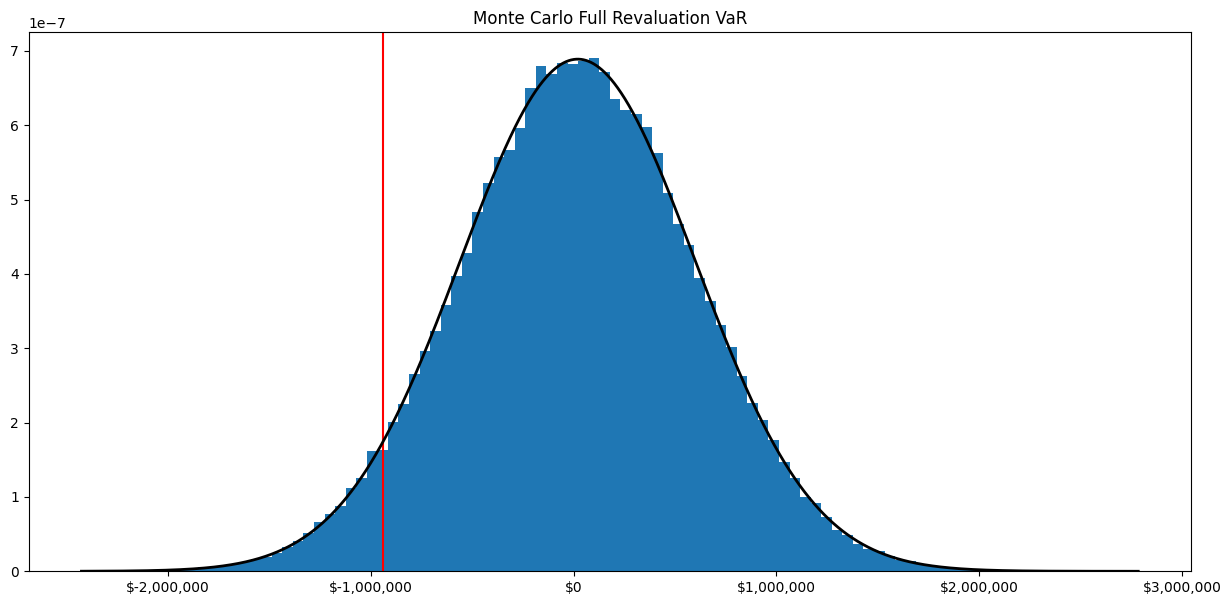

In [91]:
plot_histogram(pnl1d_full_sample, 
               var1d_full_mc, 
               'Monte Carlo Full Revaluation VaR')

### <a id = "p10b">10b.</a>  <font color = "green"> Monte Carlo VaR Sensitivity-Based Revaluation </font>  [back to table of contents](#top)

In [92]:
pnl1d_sen_sample = [ pnl1d_sen(s[0], 
                                 s[1], 
                                 s[2],
                                 s[3],
                                 s[4],
                                 s[5],
                                 s[6],
                                 s[7],
                                 s[8],
                                 s[9],
                                 s[10],
                                 s[11],
                                 s[12],
                                 s[13])  for s in return1d_sample]

# Get percentile
var1d_sen_mc = np.abs(np.percentile(pnl1d_sen_sample, VaR_percentile))

In [93]:
var1d_sen_mc

933227.098347683

In [94]:
get_distribution_statistics(pnl1d_sen_sample)

,Statistic,Value
0,Mean,22204.634563
1,Standard Deviation,578990.869448
2,Skewness,0.009228
3,Kurtosis,-0.004850


In [95]:
get_CVaR(pnl1d_sen_sample, 
        var1d_sen_mc)

Conditional Value at Risk (CVaR) at the 5% percentile is $-49601.96


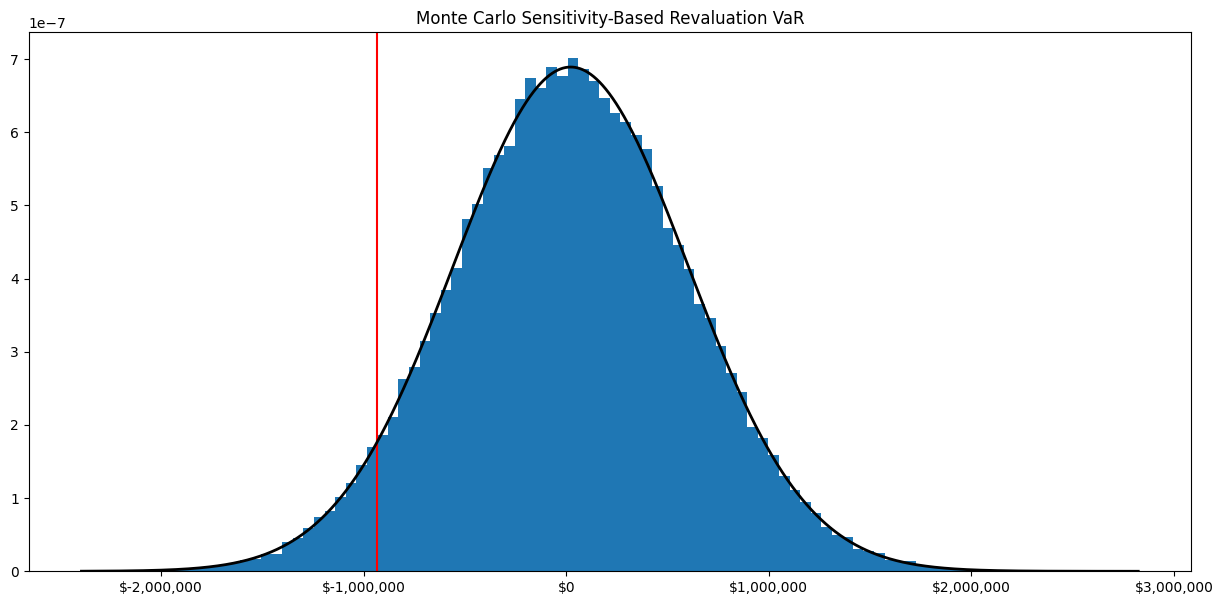

In [96]:
plot_histogram(pnl1d_sen_sample, 
               var1d_sen_mc, 
               'Monte Carlo Sensitivity-Based Revaluation VaR')

### <a id = "p10c">10c.</a>  <font color = "green"> Stocks Only Monte Carlo VaR Revaluation </font>  [back to table of contents](#top)

In [97]:
# Full revaluation 1d pnl evaluation

def stocks_only_pnl1d_full(AAPL_daily_return, 
               MSFT_daily_return, 
               FORD_daily_return,
               BAC_daily_return):
    
    stocks_only_full_reval_1d = \
        (
            stocks_notional * (AAPL_daily_return) +
            stocks_notional * (MSFT_daily_return) +
            stocks_notional * (FORD_daily_return) +
            stocks_notional * (BAC_daily_return) 
        )
    
    return stocks_only_full_reval_1d

In [98]:
# Sensitivity based 1d pnl evaluation
 
def stocks_only_pnl1d_sen(AAPL_daily_return, 
               MSFT_daily_return, 
               FORD_daily_return,
               BAC_daily_return):
    
    stocks_only_sen_reval_1d = \
        (
            stocks_notional * (AAPL_daily_return) +
            stocks_notional * (MSFT_daily_return) +
            stocks_notional * (FORD_daily_return) +
            stocks_notional * (BAC_daily_return)
        )
    
    return stocks_only_sen_reval_1d

In [99]:
n_mc = 100000

# The lower triangle matrix
stocks_only_factor_loadings = np.linalg.cholesky(stocks_only_corr_mat)

# Number of simulations, number of risk factors
stocks_only_uniforms = np.random.uniform(size=(n_mc,4))

# Convert to independent standard normal
stocks_only_snorms = [ [NormalDist().inv_cdf(u) for u in r]  for r in stocks_only_uniforms]

# Correlated standard normal
stocks_only_snorms_correlated = np.dot(stocks_only_snorms, stocks_only_factor_loadings.transpose())

In [100]:
len(stocks_only_snorms_correlated)

100000

In [101]:
# Add back the mean, scale by standard deviation
stocks_only_return1d_sample = [ [ df_all_delta["AAPL"].mean(axis=0) + df_all_delta["AAPL"].std(axis=0) * z[0],   
                                  df_all_delta["MSFT"].mean(axis=0) + df_all_delta["MSFT"].std(axis=0) * z[1], 
                                  df_all_delta["FORD"].mean(axis=0) + df_all_delta["FORD"].std(axis=0) * z[2],
                                  df_all_delta["BAC"].mean(axis=0) + df_all_delta["BAC"].std(axis=0) * z[3],]
                                for z in stocks_only_snorms_correlated]

In [102]:
# For each row, get 1 day full revaluation
stocks_only_pnl1d_full_sample = [ stocks_only_pnl1d_full(s[0], 
                                 s[1], 
                                 s[2],
                                 s[3])  for s in stocks_only_return1d_sample]

# Get percentile
stocks_only_var1d_full_mc = np.abs(np.percentile(stocks_only_pnl1d_full_sample, VaR_percentile))

In [103]:
stocks_only_var1d_full_mc

87773.71637648433

In [104]:
get_distribution_statistics(stocks_only_pnl1d_full_sample)

,Statistic,Value
0,Mean,331.475476
1,Standard Deviation,53392.028219
2,Skewness,-0.014897
3,Kurtosis,-0.015581


In [105]:
get_CVaR(stocks_only_pnl1d_full_sample, 
        stocks_only_var1d_full_mc)

Conditional Value at Risk (CVaR) at the 5% percentile is $-5498.29


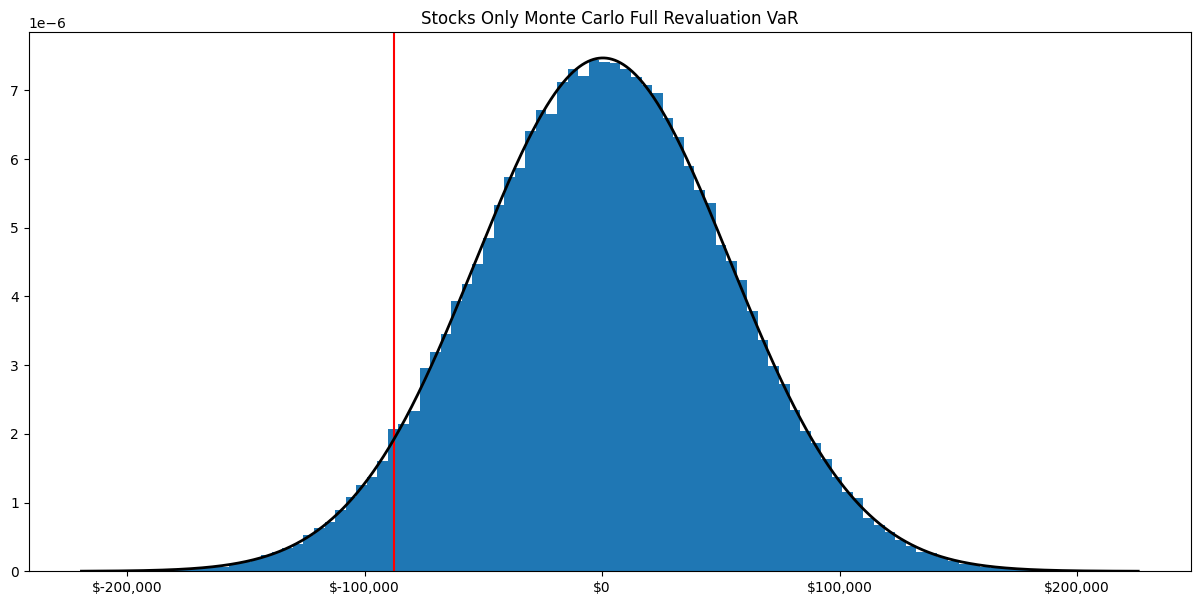

In [106]:
plot_histogram(stocks_only_pnl1d_full_sample, 
               stocks_only_var1d_full_mc, 
               'Stocks Only Monte Carlo Full Revaluation VaR')

In [107]:
stocks_only_pnl1d_sen_sample = [ stocks_only_pnl1d_sen(s[0], 
                                 s[1], 
                                 s[2],
                                 s[3])  for s in stocks_only_return1d_sample]

# Get percentile
stocks_only_var1d_sen_mc = np.abs(np.percentile(stocks_only_pnl1d_sen_sample, VaR_percentile))

In [108]:
get_distribution_statistics(stocks_only_pnl1d_sen_sample)

,Statistic,Value
0,Mean,331.475476
1,Standard Deviation,53392.028219
2,Skewness,-0.014897
3,Kurtosis,-0.015581


In [109]:
get_CVaR(stocks_only_pnl1d_sen_sample, 
        stocks_only_var1d_sen_mc)

Conditional Value at Risk (CVaR) at the 5% percentile is $-5498.29


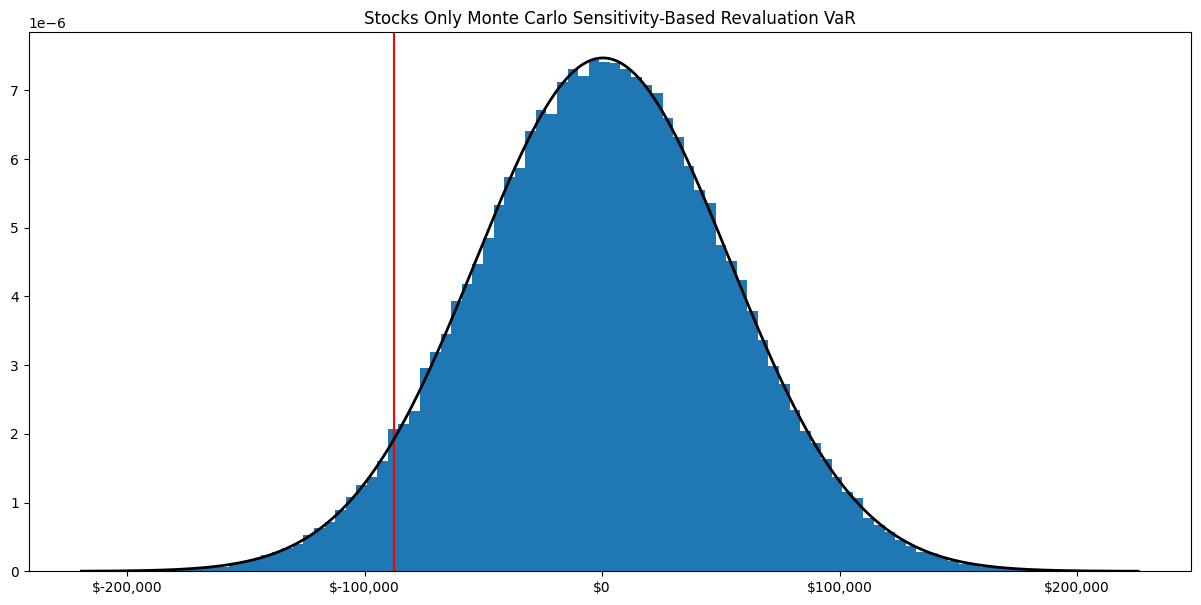

In [110]:
plot_histogram(stocks_only_pnl1d_sen_sample, 
               stocks_only_var1d_sen_mc, 
               'Stocks Only Monte Carlo Sensitivity-Based Revaluation VaR')

### <a id = "p10d">10d.</a>  <font color = "green"> Swaps Only Monte Carlo VaR Revaluation </font>  [back to table of contents](#top)

In [111]:
# Full revaluation 1d pnl evaluation

def swaps_only_pnl1d_full(
               Y1_daily_return,
               Y2_daily_return,
               Y3_daily_return,
               Y4_daily_return,
               Y5_daily_return,
               Y6_daily_return,
               Y7_daily_return,
               Y8_daily_return,
               Y9_daily_return,
               Y10_daily_return):
    
    Y1_discount_rate = np.exp(-(sofr_today[0] + Y1_daily_return)*1)
    Y2_discount_rate = np.exp(-(sofr_today[1] + Y2_daily_return)*2)
    Y3_discount_rate = np.exp(-(sofr_today[2] + Y3_daily_return)*3)
    Y4_discount_rate = np.exp(-(sofr_today[3] + Y4_daily_return)*4)
    Y5_discount_rate = np.exp(-(sofr_today[4] + Y5_daily_return)*5)
    Y6_discount_rate = np.exp(-(sofr_today[5] + Y6_daily_return)*6)
    Y7_discount_rate = np.exp(-(sofr_today[6] + Y7_daily_return)*7)
    Y8_discount_rate = np.exp(-(sofr_today[7] + Y8_daily_return)*8)
    Y9_discount_rate = np.exp(-(sofr_today[8] + Y9_daily_return)*9)
    Y10_discount_rate = np.exp(-(sofr_today[9] + Y10_daily_return)*10)
    
    swaps_only_full_reval_1d = \
        (
            PV_payer_swap(np.array([Y1_discount_rate,
                                   Y2_discount_rate,
                                   Y3_discount_rate,
                                   Y4_discount_rate,
                                   Y5_discount_rate,
                                   Y6_discount_rate,
                                   Y7_discount_rate,
                                   Y8_discount_rate,
                                   Y9_discount_rate,
                                   Y10_discount_rate])
                          )-payer_swap_today
        )
    
    return swaps_only_full_reval_1d

In [112]:
# Sensitivity based 1d pnl evaluation
 
def swaps_only_pnl1d_sen(
               Y1_daily_return,
               Y2_daily_return,
               Y3_daily_return,
               Y4_daily_return,
               Y5_daily_return,
               Y6_daily_return,
               Y7_daily_return,
               Y8_daily_return,
               Y9_daily_return,
               Y10_daily_return):
    
    swaps_only_sen_reval_1d = \
        (
            PV01[0] * Y1_daily_return +
            PV01[1] * Y2_daily_return +
            PV01[2] * Y3_daily_return +
            PV01[3] * Y4_daily_return +
            PV01[4] * Y5_daily_return +
            PV01[5] * Y6_daily_return +
            PV01[6] * Y7_daily_return +
            PV01[7] * Y8_daily_return +
            PV01[8] * Y9_daily_return +
            PV01[9] * Y10_daily_return  
        )
    
    
    return swaps_only_sen_reval_1d

In [113]:
n_mc = 100000

# The lower triangle matrix
swaps_only_factor_loadings = np.linalg.cholesky(swaps_only_corr_mat)

# Number of simulations, number of risk factors
swaps_only_uniforms = np.random.uniform(size=(n_mc,10))

# Convert to independent standard normal
swaps_only_snorms = [ [NormalDist().inv_cdf(u) for u in r]  for r in swaps_only_uniforms]

# Correlated standard normal
swaps_only_snorms_correlated = np.dot(swaps_only_snorms, swaps_only_factor_loadings.transpose())

In [114]:
# Add back the mean, scale by standard deviation
swaps_only_return1d_sample = [ [ df_all_swaps_delta["1Y"].mean(axis=0) + df_all_swaps_delta["1Y"].std(axis=0) * z[0],
                     df_all_swaps_delta["2Y"].mean(axis=0) + df_all_swaps_delta["2Y"].std(axis=0) * z[1],
                     df_all_swaps_delta["3Y"].mean(axis=0) + df_all_swaps_delta["3Y"].std(axis=0) * z[2],
                     df_all_swaps_delta["4Y"].mean(axis=0) + df_all_swaps_delta["4Y"].std(axis=0) * z[3],
                     df_all_swaps_delta["5Y"].mean(axis=0) + df_all_swaps_delta["5Y"].std(axis=0) * z[4],
                     df_all_swaps_delta["6Y"].mean(axis=0) + df_all_swaps_delta["6Y"].std(axis=0) * z[5],
                     df_all_swaps_delta["7Y"].mean(axis=0) + df_all_swaps_delta["7Y"].std(axis=0) * z[6],
                     df_all_swaps_delta["8Y"].mean(axis=0) + df_all_swaps_delta["8Y"].std(axis=0) * z[7],
                     df_all_swaps_delta["9Y"].mean(axis=0) + df_all_swaps_delta["9Y"].std(axis=0) * z[8],
                     df_all_swaps_delta["10Y"].mean(axis=0) + df_all_swaps_delta["10Y"].std(axis=0) * z[9]]  for z in swaps_only_snorms_correlated]

In [115]:
# For each row, get 1 day full revaluation
swaps_only_pnl1d_full_sample = [ swaps_only_pnl1d_full(s[0], 
                                 s[1], 
                                 s[2],
                                 s[3],
                                 s[4],
                                 s[5],
                                 s[6],
                                 s[7],
                                 s[8],
                                 s[9])  for s in swaps_only_return1d_sample]

# Get percentile
swaps_only_var1d_full_mc = np.abs(np.percentile(swaps_only_pnl1d_full_sample, VaR_percentile))

In [116]:
swaps_only_var1d_full_mc

931547.3347062159

In [117]:
get_distribution_statistics(swaps_only_pnl1d_full_sample)

,Statistic,Value
0,Mean,16654.997547
1,Standard Deviation,575847.526094
2,Skewness,-0.019890
3,Kurtosis,0.014272


In [118]:
get_CVaR(swaps_only_pnl1d_full_sample, 
        swaps_only_var1d_full_mc)

Conditional Value at Risk (CVaR) at the 5% percentile is $-50858.65


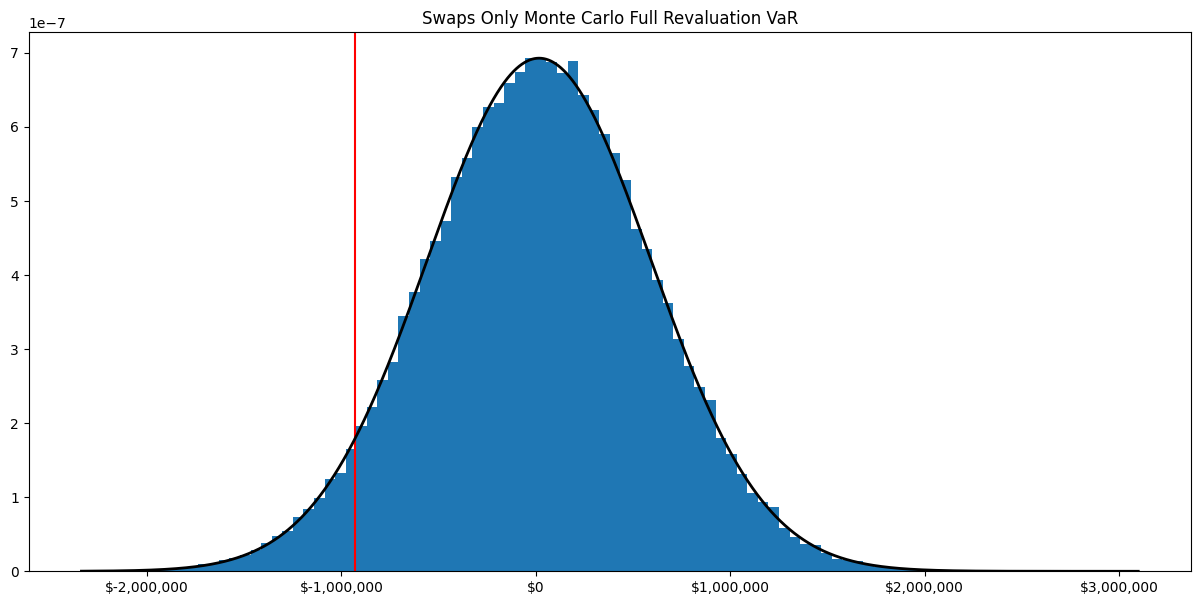

In [119]:
plot_histogram(swaps_only_pnl1d_full_sample, 
               swaps_only_var1d_full_mc, 
               'Swaps Only Monte Carlo Full Revaluation VaR')

In [120]:
swaps_only_pnl1d_sen_sample = [ swaps_only_pnl1d_sen(s[0], 
                                 s[1], 
                                 s[2],
                                 s[3],
                                 s[4],
                                 s[5],
                                 s[6],
                                 s[7],
                                 s[8],
                                 s[9])  for s in swaps_only_return1d_sample]

# Get percentile
swaps_only_var1d_sen_mc = np.abs(np.percentile(swaps_only_pnl1d_sen_sample, VaR_percentile))

In [121]:
swaps_only_var1d_sen_mc

926231.9656865508

In [122]:
get_distribution_statistics(swaps_only_pnl1d_sen_sample)

,Statistic,Value
0,Mean,18546.706944
1,Standard Deviation,575685.285513
2,Skewness,-0.000139
3,Kurtosis,0.014487


In [123]:
get_CVaR(swaps_only_pnl1d_sen_sample, 
        swaps_only_var1d_sen_mc)

Conditional Value at Risk (CVaR) at the 5% percentile is $-51288.64


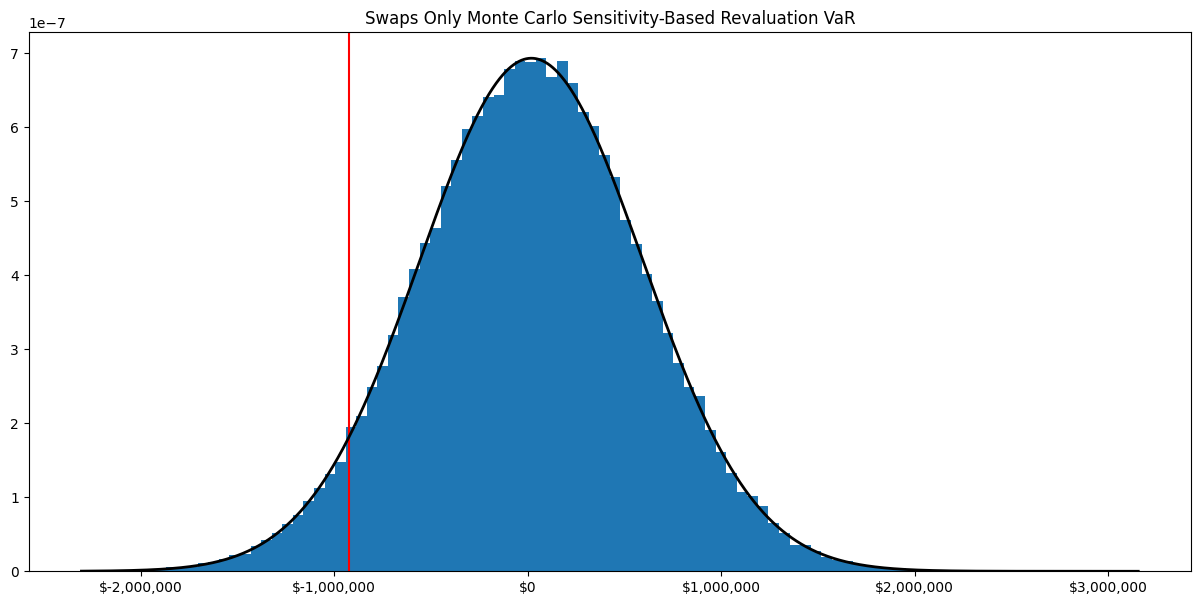

In [124]:
plot_histogram(swaps_only_pnl1d_sen_sample, 
               swaps_only_var1d_sen_mc, 
               'Swaps Only Monte Carlo Sensitivity-Based Revaluation VaR')

# <a id = "p11">11.</a>  <font color = "green"> Historical VaR Model </font>  [back to table of contents](#top)

In [125]:
hist_returns = df_all_delta.to_numpy().tolist()
hist_returns

[[-0.017542655335048063,
  -0.01705942856700049,
  0.002243790492701958,
  0.004439490637042187,
  0.0005209358738523032,
  0.0004389513015730026,
  0.00034189134015730205,
  0.00029639252967939705,
  0.0002252118467827996,
  0.0001239836941530001,
  2.8631416098601203e-05,
  -4.296202272750099e-05,
  -9.724439254459732e-05,
  -0.00014376571301889796],
 [-0.03730506042765158,
  -0.03536836367549412,
  -0.025373027871767984,
  -0.003038835198744816,
  0.00023375970802929497,
  0.0004739896266183971,
  0.0004044957208325997,
  0.0002540902371851034,
  0.00015275234096530366,
  0.00011816670926199924,
  0.00010912124093000186,
  9.866981812010206e-05,
  8.994989342100274e-05,
  9.143121885819838e-05],
 [-0.04240498469299847,
  -0.026578818852524555,
  0.015313925076559931,
  -0.005541575495642714,
  0.0006902891298441044,
  0.001097939653037304,
  0.0010846471196407984,
  0.0009568749438551016,
  0.0008321454497954017,
  0.0007607815650148009,
  0.0007037746451376004,
  0.0006239340010553

### <a id = "p11a">11a.</a>  <font color = "green"> Historical VaR Full Revaluation </font>  [back to table of contents](#top)

In [126]:
pnl1d_full_hist_sample = [ pnl1d_full(s[0], 
                                 s[1], 
                                 s[2],
                                 s[3],
                                 s[4],
                                 s[5],
                                 s[6],
                                 s[7],
                                 s[8],
                                 s[9],
                                 s[10],
                                 s[11],
                                 s[12],
                                 s[13])  for s in hist_returns]

var1d_full_hist = np.abs(np.percentile(pnl1d_full_hist_sample, VaR_percentile))

In [127]:
var1d_full_hist

984781.3920288922

In [128]:
get_distribution_statistics(pnl1d_full_hist_sample)

,Statistic,Value
0,Mean,19401.179957
1,Standard Deviation,576625.523670
2,Skewness,-0.534919
3,Kurtosis,0.642133


In [129]:
get_CVaR(pnl1d_full_hist_sample, 
        var1d_full_hist)

Conditional Value at Risk (CVaR) at the 5% percentile is $-7899.80


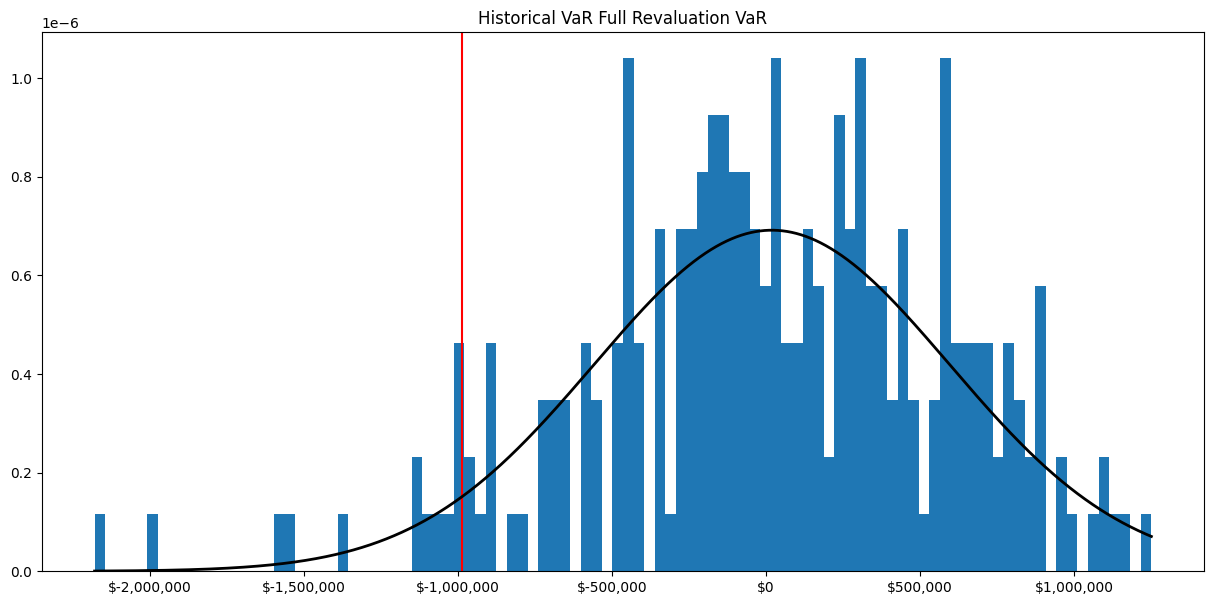

In [130]:
plot_histogram(pnl1d_full_hist_sample, 
               var1d_full_hist, 
               'Historical VaR Full Revaluation VaR')

### <a id = "p11b">11b.</a>  <font color = "green"> Historical VaR Sensitivity-Based Revaluation </font>  [back to table of contents](#top)

In [131]:
pnl1d_sen_hist_sample = [ pnl1d_sen(s[0], 
                                    s[1], 
                                    s[2],
                                    s[3],
                                    s[4],
                                    s[5],
                                    s[6],
                                    s[7],
                                    s[8],
                                    s[9],
                                    s[10],
                                    s[11],
                                    s[12],
                                    s[13])   for s in hist_returns]

var1d_sen_hist = np.abs(np.percentile(pnl1d_sen_hist_sample, VaR_percentile))

In [132]:
var1d_sen_hist 

978693.2693470919

In [133]:
get_distribution_statistics(pnl1d_sen_hist_sample)

,Statistic,Value
0,Mean,21291.782470
1,Standard Deviation,575459.309629
2,Skewness,-0.511159
3,Kurtosis,0.582977


In [134]:
get_CVaR(pnl1d_sen_hist_sample, 
        var1d_sen_hist)

Conditional Value at Risk (CVaR) at the 5% percentile is $-10158.85


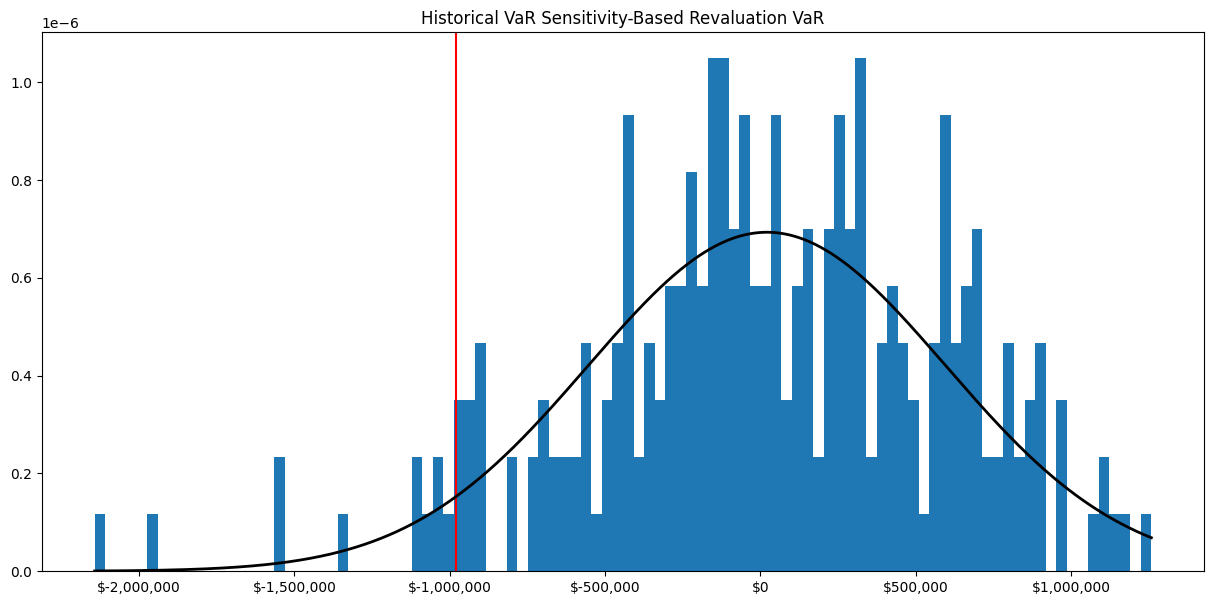

In [135]:
plot_histogram(pnl1d_sen_hist_sample, 
               var1d_sen_hist, 
               'Historical VaR Sensitivity-Based Revaluation VaR')

In [136]:
print("")
print("")
print("============================================================================================================================")
print("Historical VaR:")
print(f"VaR [1d, 95%], Full Revaluation: {var1d_full_hist:,.0f}") 
print("")
print(f"VaR [1d, 95%], Sensitivity: {var1d_sen_hist:,.0f}") 
print("============================================================================================================================")



Historical VaR:
VaR [1d, 95%], Full Revaluation: 984,781

VaR [1d, 95%], Sensitivity: 978,693


### <a id = "p11c">11c.</a>  <font color = "green"> Stock Only Historical VaR Revaluation </font>  [back to table of contents](#top)

In [137]:
stocks_only_hist_returns = df_all_stocks_delta.to_numpy().tolist()
stocks_only_hist_returns

[[-0.017542655335048063,
  -0.01705942856700049,
  0.002243790492701958,
  0.004439490637042187],
 [-0.03730506042765158,
  -0.03536836367549412,
  -0.025373027871767984,
  -0.003038835198744816],
 [-0.04240498469299847,
  -0.026578818852524555,
  0.015313925076559931,
  -0.005541575495642714],
 [-0.0019473563122850424,
  0.03332555493170841,
  0.018853703516114928,
  0.02507658517867628],
 [0.0039020935318330174,
  0.02926969215914177,
  0.014063576596144323,
  0.0059798651336249176],
 [0.0041752390440590315,
  0.004388433608539799,
  0.00145982867225114,
  0.002702065045224078],
 [-0.03319001673689448,
  -0.01905013685580581,
  -0.029883270825763253,
  -0.015898692012649818],
 [0.08897468612812465,
  0.08226801518139171,
  0.06536433769853378,
  0.044085378079473214],
 [0.019268746265275194,
  0.0169972289936271,
  0.0225669180270065,
  0.007343278708688894],
 [-0.009485648036397842,
  -0.022500001862846952,
  -0.020209025963650595,
  -0.016922689209190267],
 [0.011869329309228904,
 

In [138]:
stocks_only_pnl1d_full_hist_sample = [ stocks_only_pnl1d_full(s[0], 
                                 s[1], 
                                 s[2],
                                 s[3])  for s in stocks_only_hist_returns]

stocks_only_var1d_full_hist = np.abs(np.percentile(stocks_only_pnl1d_full_hist_sample, VaR_percentile))

In [139]:
stocks_only_var1d_full_hist

82922.76774729599

In [140]:
get_distribution_statistics(stocks_only_pnl1d_full_hist_sample)

,Statistic,Value
0,Mean,530.620360
1,Standard Deviation,53321.065547
2,Skewness,0.555243
3,Kurtosis,2.551513


In [141]:
get_CVaR(stocks_only_pnl1d_full_hist_sample, 
        stocks_only_var1d_full_hist)

Conditional Value at Risk (CVaR) at the 5% percentile is $-7192.41


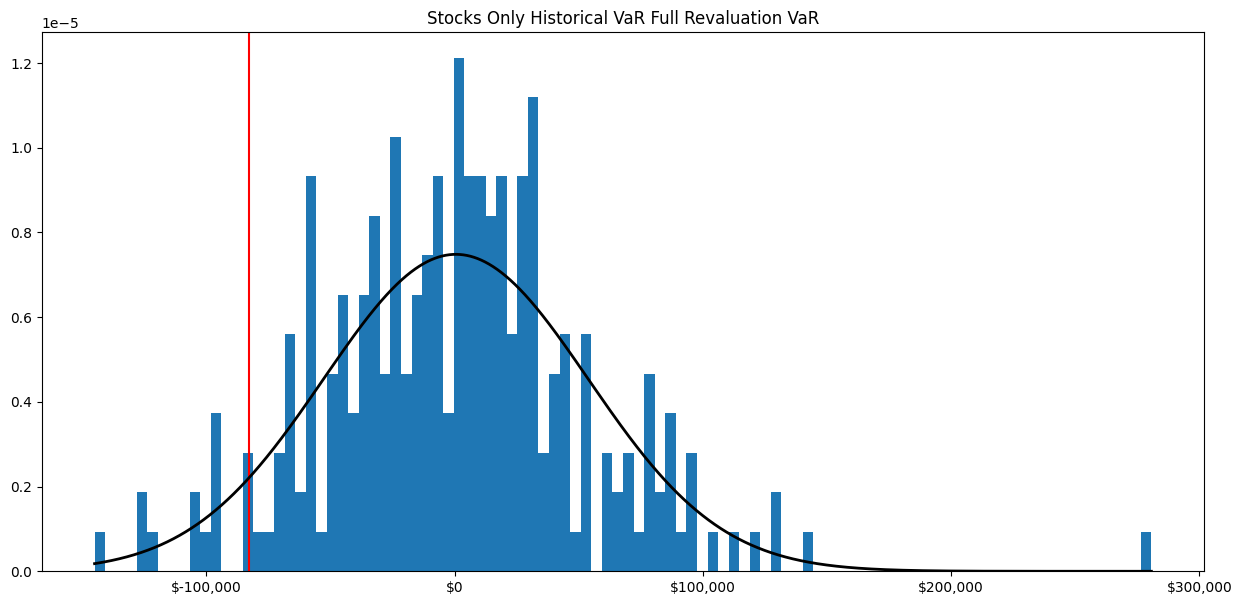

In [142]:
plot_histogram(stocks_only_pnl1d_full_hist_sample, 
               stocks_only_var1d_full_hist, 
               'Stocks Only Historical VaR Full Revaluation VaR')

In [143]:
stocks_only_pnl1d_sen_hist_sample = [ stocks_only_pnl1d_sen(s[0], 
                                    s[1], 
                                    s[2],
                                    s[3])   for s in stocks_only_hist_returns]

stocks_only_var1d_sen_hist = np.abs(np.percentile(stocks_only_pnl1d_sen_hist_sample, VaR_percentile))

In [144]:
stocks_only_var1d_sen_hist 

82922.76774729599

In [145]:
get_distribution_statistics(stocks_only_pnl1d_sen_hist_sample)

,Statistic,Value
0,Mean,530.620360
1,Standard Deviation,53321.065547
2,Skewness,0.555243
3,Kurtosis,2.551513


In [146]:
get_CVaR(stocks_only_pnl1d_sen_hist_sample, 
        stocks_only_var1d_sen_hist)

Conditional Value at Risk (CVaR) at the 5% percentile is $-7192.41


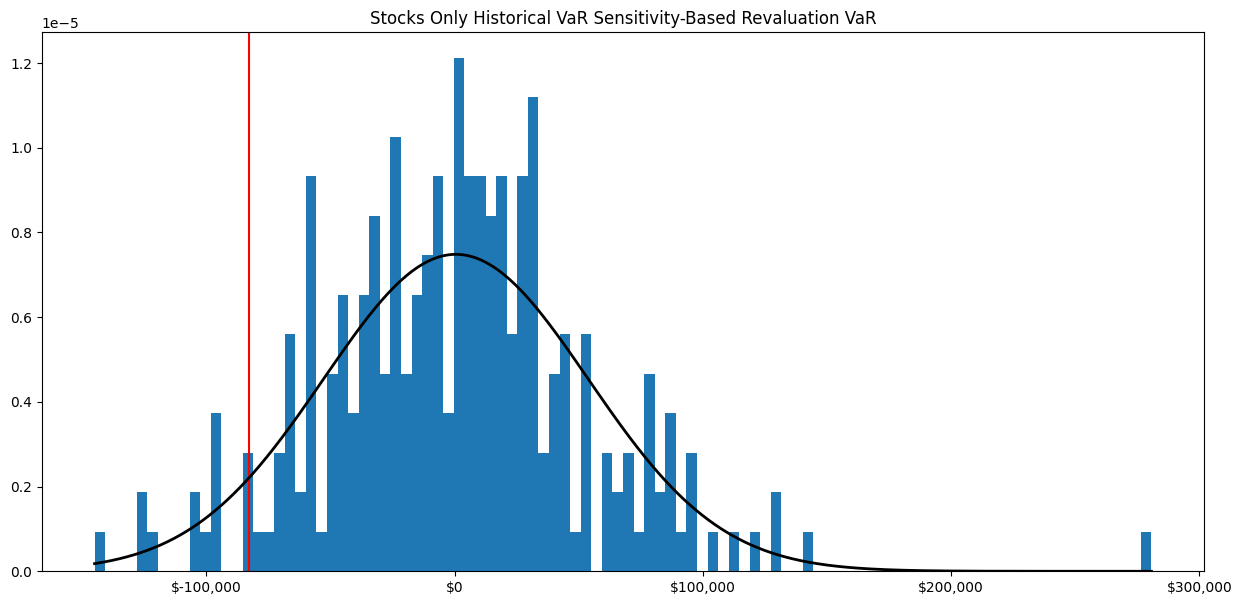

In [147]:
plot_histogram(stocks_only_pnl1d_sen_hist_sample, 
               stocks_only_var1d_sen_hist, 
               'Stocks Only Historical VaR Sensitivity-Based Revaluation VaR')

### <a id = "p11d">11d.</a>  <font color = "green"> Swaps Only Historical VaR Revaluation </font>  [back to table of contents](#top)

In [148]:
swaps_only_hist_returns = df_all_swaps_delta.to_numpy().tolist()
swaps_only_hist_returns

[[0.0005209358738523032,
  0.0004389513015730026,
  0.00034189134015730205,
  0.00029639252967939705,
  0.0002252118467827996,
  0.0001239836941530001,
  2.8631416098601203e-05,
  -4.296202272750099e-05,
  -9.724439254459732e-05,
  -0.00014376571301889796],
 [0.00023375970802929497,
  0.0004739896266183971,
  0.0004044957208325997,
  0.0002540902371851034,
  0.00015275234096530366,
  0.00011816670926199924,
  0.00010912124093000186,
  9.866981812010206e-05,
  8.994989342100274e-05,
  9.143121885819838e-05],
 [0.0006902891298441044,
  0.001097939653037304,
  0.0010846471196407984,
  0.0009568749438551016,
  0.0008321454497954017,
  0.0007607815650148009,
  0.0007037746451376004,
  0.0006239340010553984,
  0.0005446594871820962,
  0.0004953354138821017],
 [-0.00039410566843139927,
  -0.0004966621000422056,
  -0.0004479349760365958,
  -0.00032246626939590184,
  -0.00020398494324580518,
  -0.00011553988694620182,
  -3.7867491177998036e-05,
  4.548199328890251e-05,
  0.00012582182327919994,

In [149]:
swaps_only_pnl1d_full_hist_sample = [swaps_only_pnl1d_full(s[0],  
                                    s[1], 
                                    s[2],
                                    s[3],
                                    s[4],
                                    s[5],
                                    s[6],
                                    s[7],
                                    s[8],
                                    s[9])  for s in swaps_only_hist_returns]

swaps_only_var1d_full_hist = np.abs(np.percentile(swaps_only_pnl1d_full_hist_sample, VaR_percentile))

In [150]:
swaps_only_var1d_full_hist

960793.1498840059

In [151]:
get_distribution_statistics(swaps_only_pnl1d_full_hist_sample)

,Statistic,Value
0,Mean,18870.559597
1,Standard Deviation,576436.662870
2,Skewness,-0.600432
3,Kurtosis,0.982316


In [152]:
get_CVaR(swaps_only_pnl1d_full_hist_sample, 
        swaps_only_var1d_full_hist)

Conditional Value at Risk (CVaR) at the 5% percentile is $-20178.51


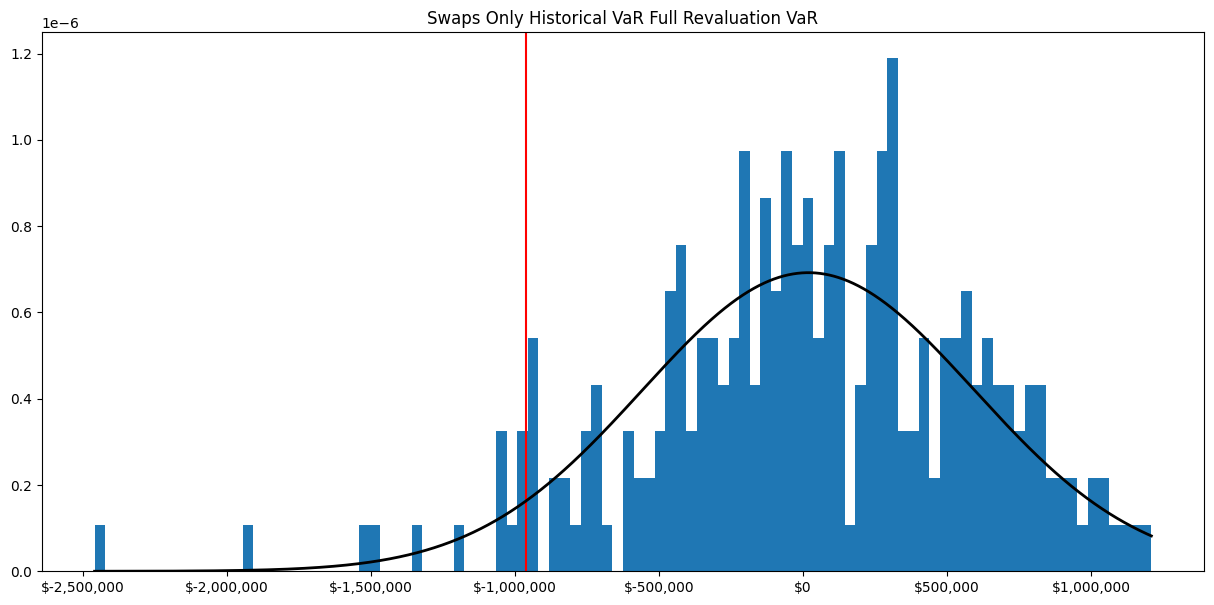

In [153]:
plot_histogram(swaps_only_pnl1d_full_hist_sample, 
               swaps_only_var1d_full_hist, 
               'Swaps Only Historical VaR Full Revaluation VaR')

In [154]:
swaps_only_pnl1d_sen_hist_sample = [ swaps_only_pnl1d_sen(s[0], 
                                    s[1], 
                                    s[2],
                                    s[3],
                                    s[4],
                                    s[5],
                                    s[6],
                                    s[7],
                                    s[8],
                                    s[9])   for s in swaps_only_hist_returns]

swaps_only_var1d_sen_hist = np.abs(np.percentile(swaps_only_pnl1d_sen_hist_sample, VaR_percentile))

In [155]:
swaps_only_var1d_sen_hist

955214.3079338076

In [156]:
get_distribution_statistics(swaps_only_pnl1d_sen_hist_sample)

,Statistic,Value
0,Mean,20761.162109
1,Standard Deviation,575221.224937
2,Skewness,-0.575037
3,Kurtosis,0.908697


In [157]:
get_CVaR(swaps_only_pnl1d_sen_hist_sample, 
        swaps_only_var1d_sen_hist)

Conditional Value at Risk (CVaR) at the 5% percentile is $-22472.30


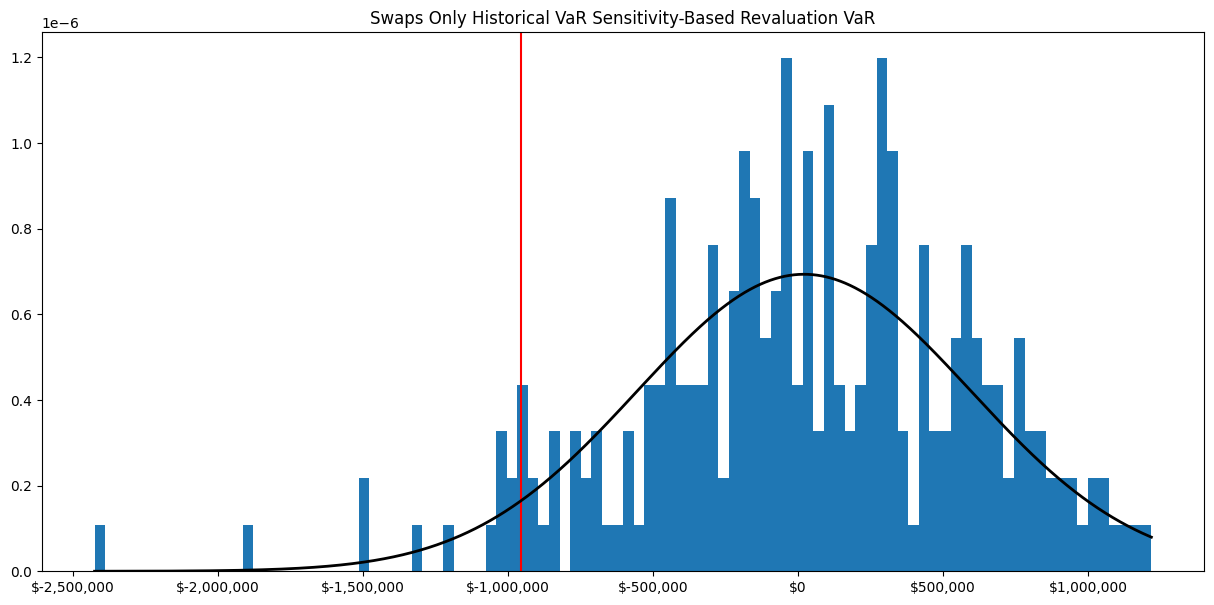

In [158]:
plot_histogram(swaps_only_pnl1d_sen_hist_sample, 
               swaps_only_var1d_sen_hist, 
               'Swaps Only Historical VaR Sensitivity-Based Revaluation VaR')